In [403]:
import numpy as np
import svm
import oracles
import optimization
from sklearn.datasets import make_classification, make_moons
from sklearn import model_selection, metrics
%matplotlib inline
from matplotlib import pyplot as plt
from importlib import reload
import time
from matplotlib.colors import ListedColormap

In [143]:
def create_dataset(complexity, n_features, n_samples, random_state=None):
    if n_features < 2:
        raise ValueError('too few features: ' + str(n_features))

    if complexity == 'not_balanced':
        coef = 0.8
    else:
        coef = 0.5

    first_sample_size = round(n_samples * coef)
    second_sample_size = n_samples - first_sample_size

    y = np.ones(n_samples)
    y[:first_sample_size] = -1

    if complexity == 'lin_sep':
        X_1 = np.random.normal(loc=3, scale=1, size=(first_sample_size, n_features))
        X_2 = np.random.normal(loc=-3, scale=1, size=(second_sample_size, n_features))
        return np.vstack((X_1, X_2)), y
    elif complexity == 'well_sep':
        X_1, y = make_moons(n_samples, random_state=44)
        y[y == 0] = -1
        if n_features > 2:
            X_2 = np.random.uniform(low=-1, high=1, size=(n_samples, n_features - 2))
            return np.hstack((X_1, X_2)), y
        return X_1, y
    elif complexity == 'badly_sep':
        X_1 = np.random.normal(loc=0, scale=1, size=(first_sample_size, n_features))
        X_2 = np.random.normal(loc=2, scale=1, size=(second_sample_size, n_features))
        return np.vstack((X_1, X_2)), y
    elif complexity == 'not_balanced':
        X_1 = np.random.normal(loc=3, scale=1, size=(first_sample_size, n_features))
        X_2 = np.random.normal(loc=-3, scale=1, size=(second_sample_size, n_features))
        return np.vstack((X_1, X_2)), y
    elif complexity == 'with_outlashes':
        num_of_outlashes = round(0.05 * n_samples)
        X_1 = np.random.normal(loc=3, scale=1, size=(first_sample_size - num_of_outlashes, n_features))
        X_2 = np.random.normal(loc=-3, scale=1, size=(second_sample_size - num_of_outlashes, n_features))
        X_3 = np.random.normal(loc=0, scale=5, size=(2 * num_of_outlashes, n_features))
        return np.vstack((X_1, X_3, X_2)), y
    raise ValueError('type ' + str(complexity) + ' is unknown')

In [144]:
def visualize_dataset(classes=[-1, 1], title='title'): # set another class mapping if there is another
    # create a mesh to plot in
    h = .02  # step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    #Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    
    # Put the result into a color plot
    #Z = Z.reshape(xx.shape)
    plt.figure()
    #plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
    plt.title(title, fontsize=16)
    #plt.axis('tight')

    # Plot also the training points
    colors = "bry"
    for i, color in zip(classes, colors):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=color, cmap=plt.cm.Paired,
                    edgecolor='black', s=20)

    # Plot the three one-against-all classifiers
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()

    def plot_hyperplane(c, color):
        def line(x0):
            return (-(x0 * coef[c, 0]) - intercept[c]) / coef[c, 1]
        plt.plot([xmin, xmax], [line(xmin), line(xmax)],
                 ls="--", color=color)

    #for i, color in zip(classes, colors):
    #    plot_hyperplane(i, color)

In [241]:
X, y = create_dataset(complexity='lin_sep', n_features=2, n_samples=100, random_state=42)

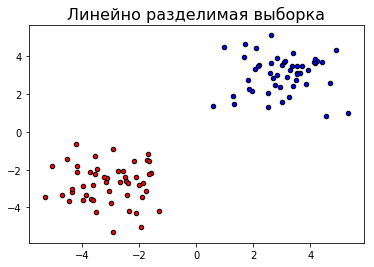

In [242]:
visualize_dataset(title='Линейно разделимая выборка')
plt.savefig('SVM_Report/pict1.pdf')

In [243]:
X, y = create_dataset(complexity='well_sep', n_features=3, n_samples=100, random_state=42)

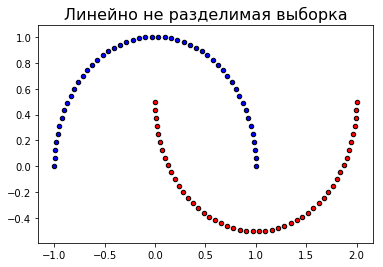

In [244]:
visualize_dataset(title='Линейно не разделимая выборка')
plt.savefig('SVM_Report/pict2.pdf')

In [245]:
X, y = create_dataset(complexity='badly_sep', n_features=2, n_samples=100, random_state=42)

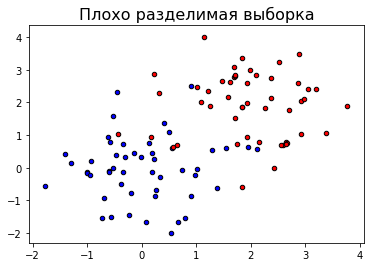

In [246]:
visualize_dataset(title='Плохо разделимая выборка')
plt.savefig('SVM_Report/pict3.pdf')

In [247]:
X, y = create_dataset(complexity='not_balanced', n_features=2, n_samples=200, random_state=42)

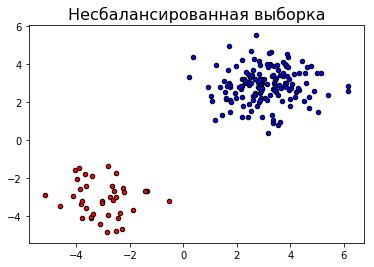

In [248]:
visualize_dataset(title='Несбалансированная выборка')
plt.savefig('SVM_Report/pict4.pdf')

In [249]:
X, y = create_dataset(complexity='with_outlashes', n_features=2, n_samples=200, random_state=42)

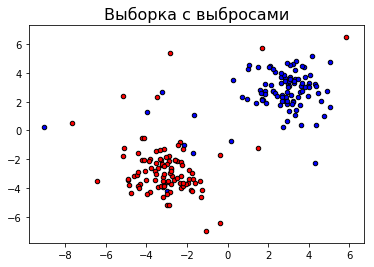

In [250]:
visualize_dataset(title='Выборка с выбросами')
plt.savefig('SVM_Report/pict5.pdf')

## Эксперимент 1

In [195]:
def measure_time(solver, solver_type, set_sizes, feature_space_sizes):
    spent_time = {'lin_sep':[],
                  'well_sep':[],
                  'badly_sep':[],
                  'not_balanced':[],
                  'with_outlashes':[]}

    score = {'lin_sep':[],
             'well_sep':[],
             'badly_sep':[],
             'not_balanced':[],
             'with_outlashes':[]}

    for n_samples in set_sizes:
        for complexity in spent_time:
            X, y = create_dataset(complexity=complexity, n_features=feature_space_sizes[0],
                                  n_samples=n_samples, random_state=42)
            start_time = time.time()
            solver.fit(X, y)
            finish_time = time.time() - start_time
            spent_time[complexity].append(finish_time)
            if solver_type == 'primal':
                target_val = solver.compute_primal_objective(X, y)
            elif solver_type == 'dual':
                target_val = -solver.compute_dual_objective(X, y)
            elif solver_type == 'pegasos':
                target_val = oracles.BinaryHinge(C=1000).func(np.hstack((np.ones(X.shape[0])[:, np.newaxis], X)),
                                                              y, solver.w)
            score[complexity].append(target_val)

    for n_features in feature_space_sizes:
        for complexity in spent_time:
            X, y = create_dataset(complexity=complexity, n_features=n_features, n_samples=set_sizes[0],
                                  random_state=42)
            start_time = time.time()
            solver.fit(X, y)
            finish_time = time.time() - start_time
            spent_time[complexity].append(finish_time)
            if solver_type == 'primal':
                target_val = solver.compute_primal_objective(X, y)
            elif solver_type == 'dual':
                target_val = -solver.compute_dual_objective(X, y)
            elif solver_type == 'pegasos':
                target_val = oracles.BinaryHinge(C=1000).func(np.hstack((np.ones(X.shape[0])[:, np.newaxis], X)),
                                                              y, solver.w)
            score[complexity].append(target_val)

    return spent_time, score

In [196]:
reload(svm)

set_sizes = [100, 500, 1000]
feature_space_sizes = [100, 500, 1000]

primal_time, primal_target = measure_time(svm.SVMSolver(C=1000, method='primal'), 'primal',
                                          set_sizes, feature_space_sizes)
dual_time, dual_target = measure_time(svm.SVMSolver(C=1000, method='dual'), 'dual',
                                      set_sizes, feature_space_sizes)
pegasos_time, pegasos_target = measure_time(optimization.PEGASOSMethod(C=1000), 'pegasos',
                                            set_sizes, feature_space_sizes)

     pcost       dcost       gap    pres   dres
 0: -9.9897e+03  1.3474e+03  3e+03  2e+01  1e+01
 1: -3.2335e+02 -5.0337e+01  1e+02  6e-01  5e-01
 2: -6.5655e+00 -1.7504e+00  4e+00  1e-02  1e-02
 3:  1.6736e-01 -1.4387e-01  4e-01  8e-05  7e-05
 4:  4.2525e-02 -9.7460e-03  5e-02  3e-15  8e-16
 5:  1.1538e-02  4.9547e-03  7e-03  1e-15  4e-16
 6:  7.5838e-03  6.0963e-03  1e-03  8e-16  2e-16
 7:  7.1401e-03  6.6729e-03  5e-04  7e-16  2e-16
 8:  6.9823e-03  6.8996e-03  8e-05  7e-16  3e-16
 9:  6.9479e-03  6.9456e-03  2e-06  7e-16  4e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -9.9987e+03  1.1308e+03  3e+03  2e+01  3e+01
 1: -1.7634e+02 -2.2971e+01  6e+01  3e-01  6e-01
 2: -2.7858e+00 -4.4678e-01  1e+00  5e-03  1e-02
 3:  5.5201e-03 -2.6600e-02  6e-02  5e-05  1e-04
 4:  6.4524e-03 -2.3550e-03  9e-03  3e-15  1e-15
 5:  1.5347e-03  3.5499e-04  1e-03  1e-15  4e-16
 6:  6.9237e-04  5.6881e-04  1e-04  5e-16  4e-16
 7:  6.7186e-04  6.0306e-04  7e-05  5e-16  6e-1

11:  1.1122e-01  1.0338e-01  8e-03  2e-07  7e-05
12:  1.1159e-01  1.0366e-01  8e-03  2e-07  6e-05
13:  1.0994e-01  1.0493e-01  5e-03  1e-15  2e-15
14:  1.0770e-01  1.0647e-01  1e-03  1e-15  4e-15
15:  1.0704e-01  1.0700e-01  4e-05  1e-15  5e-15
16:  1.0702e-01  1.0702e-01  5e-07  1e-15  3e-14
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -9.9908e+02  1.1006e+03  5e+03  3e+00  1e+03
 1:  2.5958e+02 -8.9557e+01  4e+02  1e-01  4e+01
 2:  4.0263e+00 -1.1201e+00  6e+00  1e-03  5e-01
 3:  4.5902e-02 -1.2951e-02  7e-02  1e-05  5e-03
 4:  2.8645e-03 -1.5884e-04  3e-03  1e-07  5e-05
 5:  8.5374e-04  5.3887e-04  3e-04  8e-16  3e-16
 6:  6.7447e-04  5.6829e-04  1e-04  5e-16  2e-16
 7:  6.9694e-04  5.8580e-04  1e-04  5e-16  5e-16
 8:  6.8146e-04  6.0876e-04  7e-05  4e-16  4e-16
 9:  6.9192e-04  6.2128e-04  7e-05  4e-16  3e-16
10:  6.5921e-04  6.3488e-04  2e-05  4e-16  3e-16
11:  6.5279e-04  6.3703e-04  2e-05  4e-16  2e-16
12:  6.4452e-04  6.4283e-04  2e-06  5e-16  3e-

 6:  3.1371e-04  2.6828e-04  5e-05  2e-15  1e-15
 7:  2.8052e-04  2.7167e-04  9e-06  1e-15  7e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.0000e+04  1.0003e+03  2e+03  2e+01  9e+01
 1: -9.4661e+01 -1.1119e+01  3e+01  2e-01  1e+00
 2: -1.3552e+00 -1.6928e-01  4e-01  2e-03  1e-02
 3: -7.5580e-03 -6.2784e-03  1e-02  2e-05  1e-04
 4:  1.1944e-03 -6.2767e-04  2e-03  1e-14  2e-15
 5:  2.4892e-04 -7.0082e-06  3e-04  5e-15  9e-16
 6:  8.2457e-05  5.3361e-05  3e-05  2e-15  1e-15
 7:  5.7835e-05  5.5811e-05  2e-06  1e-15  5e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -9.9495e+03 -1.4576e+01  1e+03  2e+01  2e-14
 1: -1.0433e+02 -1.8763e+00  2e+01  2e-01  3e-15
 2: -3.7520e-01 -4.5431e-02  8e-01  2e-03  3e-15
 3:  2.2987e-01  1.4142e-01  9e-02  2e-15  3e-15
 4:  1.5279e-01  1.4941e-01  3e-03  1e-15  4e-16
 5:  1.4946e-01  1.4943e-01  3e-05  1e-15  4e-16
 6:  1.4943e-01  1.4943e-01  3e-07  1e-15  4e-16
Optimal solution found.

 7: -5.9761e-04 -7.6095e-04  2e-04  2e-16  4e-16
 8: -6.1037e-04 -7.7501e-04  2e-04  3e-16  4e-16
 9: -6.4664e-04 -7.1218e-04  7e-05  2e-16  5e-16
10: -6.4862e-04 -7.1644e-04  7e-05  2e-16  4e-16
11: -6.5805e-04 -6.9268e-04  3e-05  2e-16  4e-16
12: -6.5871e-04 -6.8763e-04  3e-05  2e-16  5e-16
13: -6.6556e-04 -6.7716e-04  1e-05  2e-16  4e-16
14: -6.6828e-04 -6.7256e-04  4e-06  2e-16  5e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -4.8292e+01 -1.5841e+03  8e+03  2e+00  3e-12
 1: -3.0072e+01 -7.4106e+02  1e+03  3e-01  2e-12
 2: -1.5298e+01 -3.7899e+02  6e+02  1e-01  1e-12
 3:  4.7502e-02 -5.1947e+01  7e+01  9e-03  9e-13
 4:  4.6378e-02 -7.5828e+00  1e+01  1e-03  1e-13
 5: -5.2512e-02 -5.6419e-01  6e-01  6e-05  8e-15
 6: -7.5621e-02 -2.4342e-01  2e-01  1e-05  4e-15
 7: -8.7491e-02 -1.3779e-01  5e-02  2e-16  4e-15
 8: -9.1513e-02 -1.1710e-01  3e-02  2e-16  3e-15
 9: -9.2281e-02 -1.1785e-01  3e-02  2e-16  3e-15
10: -9.6474e-02 -1.0867e-01  1e-02  2e-16  4e-

 7: -5.5664e-05 -5.8467e-05  3e-06  2e-16  2e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.8626e-02 -1.0006e+03  2e+03  1e-01  9e-15
 1:  3.4387e-02 -1.8884e+01  3e+01  1e-03  4e-15
 2:  2.7861e-02 -3.8301e-01  6e-01  3e-05  7e-15
 3:  8.8404e-03 -1.5774e-02  3e-02  3e-07  3e-15
 4:  8.6120e-04 -2.5115e-03  3e-03  2e-16  3e-15
 5: -1.7917e-04 -6.2770e-04  4e-04  2e-16  1e-15
 6: -2.6453e-04 -3.0481e-04  4e-05  2e-16  4e-16
 7: -2.6759e-04 -2.7463e-04  7e-06  2e-16  2e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  6.0522e-03 -1.0004e+03  2e+03  1e-01  6e-15
 1:  7.2745e-03 -1.8633e+01  3e+01  1e-03  5e-15
 2:  6.6433e-03 -2.8080e-01  5e-01  2e-05  6e-15
 3:  4.9140e-03 -8.8065e-03  2e-02  2e-07  3e-15
 4:  6.3414e-04 -1.2030e-03  2e-03  2e-16  2e-15
 5:  7.7191e-06 -2.5045e-04  3e-04  2e-16  1e-15
 6: -5.3328e-05 -8.2731e-05  3e-05  2e-16  4e-16
 7: -5.5799e-05 -5.9085e-05  3e-06  2e-16  2e-16
Optimal solution found.

In [197]:
primal_time

{'badly_sep': [0.08233928680419922,
  0.9571981430053711,
  5.185477018356323,
  0.04252505302429199,
  0.28621697425842285,
  1.2092843055725098],
 'lin_sep': [0.16548538208007812,
  1.1298329830169678,
  5.591943025588989,
  0.04339432716369629,
  0.456798791885376,
  1.0086727142333984],
 'not_balanced': [0.06629681587219238,
  1.1754744052886963,
  5.230525970458984,
  0.04296231269836426,
  0.7049486637115479,
  1.002058506011963],
 'well_sep': [0.18513917922973633,
  1.0906541347503662,
  5.602014541625977,
  0.08783197402954102,
  0.3235189914703369,
  0.8647782802581787],
 'with_outlashes': [0.114349365234375,
  1.575864553451538,
  6.8107545375823975,
  0.05460023880004883,
  0.2979147434234619,
  1.046011209487915]}

In [198]:
primal_target

{'badly_sep': [0.0069471935448013429,
  0.0078753602504955753,
  0.0080636813220259299,
  0.0065711647242947865,
  0.0010783515920464622,
  0.00052515954768312626],
 'lin_sep': [0.00061335857348796018,
  0.0006459025694877153,
  0.00064371973099330826,
  0.00061375409633912124,
  0.00012022525629410991,
  5.7755678997719085e-05],
 'not_balanced': [0.00064001963420156011,
  0.00067092634292353394,
  0.00065577624331463131,
  0.00060799545881975298,
  0.00011935210204077721,
  5.8095025469587246e-05],
 'well_sep': [2.3134799605984799,
  104.69351184782532,
  191.21038817234808,
  2.0634519205750461,
  0.33614791321296789,
  0.14942666347773936],
 'with_outlashes': [0.0030880340586047269,
  0.028292479992813129,
  0.10701993909603034,
  0.0027879067597519069,
  0.00051019324069460773,
  0.0002800787762740894]}

In [199]:
dual_time

{'badly_sep': [0.04716897010803223,
  0.6320936679840088,
  5.114874839782715,
  0.022897720336914062,
  0.029573917388916016,
  0.02518439292907715],
 'lin_sep': [0.02212810516357422,
  0.72723388671875,
  4.289651870727539,
  0.025259971618652344,
  0.019054174423217773,
  0.024796247482299805],
 'not_balanced': [0.034512996673583984,
  0.7386982440948486,
  5.071160078048706,
  0.022587299346923828,
  0.059027910232543945,
  0.03053426742553711],
 'well_sep': [0.030019521713256836,
  0.7158944606781006,
  4.385365962982178,
  0.023788928985595703,
  0.03148221969604492,
  0.020177125930786133],
 'with_outlashes': [0.025578022003173828,
  0.8725533485412598,
  5.265871047973633,
  0.026857376098632812,
  0.023051738739013672,
  0.02690911293029785]}

In [200]:
dual_target

{'badly_sep': [0.0059908535454311317,
  0.0080057828713583131,
  0.0085669050111906002,
  0.0059577332230684003,
  0.0010885510740645202,
  0.00053686910337932391],
 'lin_sep': [0.00062428098701256722,
  0.00064269232736286343,
  0.00069006416997483369,
  0.00062754561177400523,
  0.00011197330396632503,
  5.5798977348451786e-05],
 'not_balanced': [0.00062644265390404284,
  0.00065717991269312304,
  0.0006682848687975723,
  0.0006101392649617614,
  0.00011138456899163437,
  5.5663784039776637e-05],
 'well_sep': [3.0247883903488431,
  108.60137615389255,
  179.52418062988966,
  1.9312663846837146,
  0.31345035419812184,
  0.15539161976694804],
 'with_outlashes': [0.0028858675738773322,
  0.017864037342268956,
  0.1003752245661594,
  0.0028216072011516026,
  0.00053627755756090005,
  0.00026759344693918276]}

In [201]:
pegasos_time

{'badly_sep': [0.045449018478393555,
  0.0480804443359375,
  0.05318570137023926,
  0.05122232437133789,
  0.056163787841796875,
  0.10417699813842773],
 'lin_sep': [0.044085025787353516,
  0.04387187957763672,
  0.06190133094787598,
  0.0424041748046875,
  0.06526899337768555,
  0.11780452728271484],
 'not_balanced': [0.0949561595916748,
  0.0543360710144043,
  0.04895329475402832,
  0.041214942932128906,
  0.054222822189331055,
  0.09470987319946289],
 'well_sep': [0.05912494659423828,
  0.049783945083618164,
  0.06833052635192871,
  0.04776167869567871,
  0.07806682586669922,
  0.11859822273254395],
 'with_outlashes': [0.043196678161621094,
  0.05032634735107422,
  0.05094432830810547,
  0.0416874885559082,
  0.06565403938293457,
  0.1076192855834961]}

In [202]:
pegasos_target

{'badly_sep': [551.60612666832969,
  555.22610279509581,
  619.95349292652577,
  574.39324027705356,
  553.38110299543678,
  486.14958251227984],
 'lin_sep': [1.1952648840603968,
  0.3423839968105496,
  0.00076478354475683177,
  1.6052153584871947,
  0.00012183164577791696,
  0.0064411255840905561],
 'not_balanced': [0.43585198341863174,
  0.098069369259568454,
  0.00071242748269559971,
  0.40322032024485444,
  0.00012178829548742054,
  0.016616009244744274],
 'well_sep': [1186.6251278944271,
  1182.0363945855497,
  1181.5386593895632,
  1203.0462249114355,
  1090.8718631057488,
  1028.6035504201352],
 'with_outlashes': [91.162457296043513,
  105.38691832121205,
  105.22461275301319,
  113.5556865317436,
  95.916832539237802,
  96.369690484093766]}

## Эксперимент 2

In [293]:
reload(svm)

set_sizes = [100, 500, 1000]
feature_space_sizes = [100, 500, 1000]

poly_time, poly_target = measure_time(svm.SVMSolver(C=1000, method='dual', kernel='polynomial', degree=3), 'dual',
                                      set_sizes, feature_space_sizes)
rbf_time, rbf_target = measure_time(svm.SVMSolver(C=1000, method='dual', kernel='rbf', gamma=10), 'dual',
                                      set_sizes, feature_space_sizes)

     pcost       dcost       gap    pres   dres
 0:  9.5177e-06 -1.0000e+03  2e+03  1e-01  6e-15
 1:  1.1500e-05 -1.8252e+01  3e+01  1e-03  7e-15
 2:  1.1536e-05 -1.8292e-01  3e-01  1e-05  8e-15
 3:  1.1402e-05 -2.2115e-03  4e-03  2e-07  7e-15
 4:  6.6638e-06 -2.6878e-04  4e-04  2e-08  5e-15
 5:  3.3931e-06 -3.1548e-05  5e-05  1e-09  4e-15
 6:  9.9484e-07 -1.7342e-06  3e-06  1e-11  5e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  6.8000e-07 -1.0000e+03  2e+03  1e-01  5e-14
 1:  8.2161e-07 -1.8252e+01  3e+01  1e-03  3e-14
 2:  8.2425e-07 -1.8262e-01  3e-01  1e-05  3e-14
 3:  8.1595e-07 -1.9112e-03  3e-03  1e-07  4e-14
 4:  3.9631e-07 -7.3637e-05  1e-04  6e-09  3e-14
 5:  8.5239e-08 -3.7030e-06  6e-06  3e-10  3e-14
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  5.2690e-07 -1.0000e+03  2e+03  1e-01  3e-14
 1:  6.3663e-07 -1.8252e+01  3e+01  1e-03  2e-14
 2:  6.3869e-07 -1.8260e-01  3e-01  1e-05  2e-14
 3:  6.3391e-07 -1.8877e

 1:  1.1094e-09 -1.8252e+01  3e+01  1e-03  4e-15
 2:  1.1131e-09 -1.8253e-01  3e-01  1e-05  4e-15
 3:  1.1132e-09 -1.8254e-03  3e-03  1e-07  4e-15
 4:  1.1123e-09 -1.8350e-05  3e-05  1e-09  4e-15
 5:  1.0335e-09 -2.7006e-07  4e-07  2e-11  4e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.0507e-03 -1.0000e+03  1e+03  5e-17  4e-15
 1:  1.3468e-04 -1.0000e+01  1e+01  2e-16  5e-15
 2:  3.3530e-06 -1.0005e-01  1e-01  2e-16  2e-15
 3: -1.0007e-05 -1.0163e-03  1e-03  2e-16  8e-16
 4: -1.0611e-05 -2.0907e-05  1e-05  2e-16  5e-16
 5: -1.0613e-05 -1.0716e-05  1e-07  2e-16  4e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  3.4910e-09 -1.0000e+03  2e+03  1e-01  4e-15
 1:  4.2180e-09 -1.8252e+01  3e+01  1e-03  4e-15
 2:  4.2320e-09 -1.8253e-01  3e-01  1e-05  5e-15
 3:  4.2321e-09 -1.8254e-03  3e-03  1e-07  4e-15
 4:  4.2315e-09 -1.8317e-05  3e-05  1e-09  5e-15
 5:  4.1798e-09 -2.4368e-07  4e-07  2e-11  5e-15
Optimal solution found.

 2: -4.9538e+02 -5.0562e+02  1e+01  9e-16  2e-17
 3: -4.9933e+02 -5.0075e+02  1e+00  2e-15  6e-17
 4: -4.9990e+02 -5.0011e+02  2e-01  2e-16  5e-17
 5: -4.9999e+02 -5.0002e+02  3e-02  2e-15  1e-17
 6: -5.0000e+02 -5.0000e+02  4e-03  3e-15  5e-17
 7: -5.0000e+02 -5.0000e+02  6e-04  2e-15  4e-17
 8: -5.0000e+02 -5.0000e+02  9e-05  2e-16  4e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  3.0556e+02 -1.6722e+03  2e+03  9e-16  1e-15
 1:  2.4567e-01 -2.1049e+02  2e+02  1e-16  4e-16
 2: -4.8158e+01 -7.3125e+01  2e+01  1e-15  3e-16
 3: -4.9997e+01 -5.0737e+01  7e-01  5e-15  7e-17
 4: -5.0000e+01 -5.0007e+01  7e-03  7e-15  6e-17
 5: -5.0000e+01 -5.0000e+01  7e-05  4e-16  5e-17
 6: -5.0000e+01 -5.0000e+01  7e-07  4e-16  9e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.9556e+02 -2.3102e+03  3e+03  5e-15  2e-15
 1:  4.6163e+01 -3.0561e+02  4e+02  5e-14  8e-16
 2: -2.7081e+01 -6.7672e+01  4e+01  4e-14  2e-16
 3: -3.1960e+01 -3.4438

In [294]:
poly_time

{'badly_sep': [0.04442763328552246,
  0.7430191040039062,
  2.8216958045959473,
  0.039464473724365234,
  0.017454147338867188,
  0.031167984008789062],
 'lin_sep': [0.05382847785949707,
  0.46082377433776855,
  2.5414302349090576,
  0.0161135196685791,
  0.056998491287231445,
  0.020459890365600586],
 'not_balanced': [0.06203579902648926,
  0.666581392288208,
  2.462480306625366,
  0.015680789947509766,
  0.0157773494720459,
  0.025180816650390625],
 'well_sep': [0.07410120964050293,
  0.4330427646636963,
  2.2006688117980957,
  0.014786243438720703,
  0.033286333084106445,
  0.02266669273376465],
 'with_outlashes': [0.06883645057678223,
  0.5858538150787354,
  2.5853395462036133,
  0.01589488983154297,
  0.016756534576416016,
  0.07165741920471191]}

In [295]:
poly_target

{'badly_sep': [-9.9484006345220119e-07,
  -1.189805645179751e-07,
  -1.9263459744805851e-07,
  -1.2694753488813139e-06,
  -3.1430766698857222e-08,
  -4.1798001176665604e-09],
 'lin_sep': [-9.025142731460935e-08,
  -4.1599646152753946e-09,
  9.4821450034178954e-10,
  -8.7926056639626694e-08,
  -1.0335020338341115e-09,
  -1.0965838711106998e-10],
 'not_balanced': [-8.5238950986811691e-08,
  -4.2541403521337195e-09,
  2.6007168590235457e-09,
  -8.0215041010208054e-08,
  -9.4847452439767678e-10,
  -1.0579674457980493e-10],
 'well_sep': [0.0012060894675168863,
  0.0053820454369743875,
  0.0099677283681175403,
  0.0011107759731460974,
  1.0612868898580171e-05,
  6.3334708031371055e-07],
 'with_outlashes': [-1.3236784466525253e-07,
  -1.2669350824793149e-08,
  -8.8028258832067432e-09,
  -1.2504312939410223e-07,
  -1.2291530571330919e-09,
  -1.3983882713147974e-10]}

In [296]:
rbf_time

{'badly_sep': [0.018397092819213867,
  0.37598538398742676,
  3.2932324409484863,
  0.02700352668762207,
  0.023896455764770508,
  0.042034149169921875],
 'lin_sep': [0.01834273338317871,
  0.42263054847717285,
  3.2766506671905518,
  0.020285367965698242,
  0.025592565536499023,
  0.030184268951416016],
 'not_balanced': [0.018578290939331055,
  0.3433830738067627,
  2.462561845779419,
  0.01950693130493164,
  0.06803655624389648,
  0.0457301139831543],
 'well_sep': [0.09315657615661621,
  2.0248560905456543,
  21.912527322769165,
  0.04512310028076172,
  0.022406816482543945,
  0.030636072158813477],
 'with_outlashes': [0.018167972564697266,
  0.3418881893157959,
  3.295182228088379,
  0.01922464370727539,
  0.025607585906982422,
  0.0291903018951416]}

In [297]:
rbf_target

{'badly_sep': [50.000000000000007,
  250.0,
  499.99995930083963,
  50.000000000000007,
  50.000000000000007,
  50.000000000000007],
 'lin_sep': [50.000000000000007,
  250.0,
  499.99995930083963,
  50.000000000000007,
  50.000000000000007,
  50.000000000000007],
 'not_balanced': [31.999999999999929,
  159.99999999999991,
  274.9999951391901,
  31.999999999999929,
  31.999999999999929,
  31.999999999999929],
 'well_sep': [50.000000000000007,
  250.0,
  499.99995930083952,
  50.000000000000007,
  50.000000000000007,
  50.000000000000007],
 'with_outlashes': [50.000000000000007,
  250.0,
  499.99995930083963,
  50.000000000000007,
  50.000000000000007,
  50.000000000000007]}

## Эксперимент 3

## Эксперимент 4

In [522]:
reload(svm)
poly_score = []
rbf_score = []
datasets = ['lin_sep', 'well_sep', 'badly_sep']
C_values = {'C':[1e-3, 1e-2, 1e-1, 1, 10, 100, 1000]}
for dataset in datasets:
    X, y = create_dataset(complexity=dataset, n_features=2, n_samples=500, random_state=42)
    poly = svm.SVMSolver(C=1000, method='dual', kernel='polynomial')
    grid = model_selection.GridSearchCV(poly, C_values, scoring=metrics.make_scorer(metrics.accuracy_score),
                                        n_jobs=-1, cv=4)
    grid.fit(X, y)
    poly_score.append(grid.cv_results_['mean_test_score'])

    rbf = svm.SVMSolver(C=1000, method='dual', kernel='rbf')
    grid = model_selection.GridSearchCV(rbf, C_values, scoring=metrics.make_scorer(metrics.accuracy_score),
                                        n_jobs=-1, cv=4)
    grid.fit(X, y)
    rbf_score.append(grid.cv_results_['mean_test_score'])

     pcost       dcost       gap    pres   dres
 0: -2.5026e+00 -2.0878e-02  1e+03  3e+01  1e-11
     pcost       dcost       gap    pres   dres
     pcost       dcost       gap    pres   dres
     pcost       dcost       gap    pres   dres
 0: -2.5189e+00 -2.1612e-02  1e+03  4e+01  7e-12
 0: -2.5437e+00 -2.1174e-02  1e+03  3e+01  9e-12
 0: -2.1711e+00 -2.1147e-02  1e+03  4e+01  7e-12
 1: -4.6261e-02 -2.0821e-02  1e+01  4e-01  1e-11
 1: -4.6476e-02 -2.1542e-02  1e+01  4e-01  7e-12
 1: -4.2693e-02 -2.1084e-02  1e+01  4e-01  7e-12
 2: -2.1080e-02 -1.6562e-02  9e-01  2e-02  7e-13
 1: -4.6254e-02 -2.1104e-02  1e+01  4e-01  8e-12
 2: -2.0921e-02 -1.6423e-02  8e-01  2e-02  5e-13
 3: -6.9297e-03 -2.4604e-03  1e-01  3e-03  8e-14
 2: -2.0606e-02 -1.5894e-02  6e-01  2e-02  4e-13
 2: -2.1100e-02 -1.6499e-02  6e-01  2e-02  4e-13
 3: -5.4576e-03 -2.1243e-03  9e-02  2e-03  6e-14
 3: -2.6264e-03 -1.7861e-03  4e-02  1e-03  4e-14
 4: -7.5828e-04 -1.6377e-03  8e-03  2e-04  7e-15
 3: -3.1557e-03 -1.8272e

 5: -2.9264e-02 -8.8215e-02  9e-02  9e-04  3e-14
 4: -3.2349e-02 -2.0430e-01  2e-01  2e-03  6e-14
 6: -2.4773e-02 -5.7170e-02  6e-02  5e-04  2e-14
 1: -5.8050e-02 -1.3199e+00  1e+01  4e-01  8e-12
 5: -2.9275e-02 -7.2846e-02  7e-02  6e-04  2e-14
 2: -2.9835e-02 -9.5377e-01  1e+00  2e-02  4e-13
 7: -2.1116e-02 -4.0851e-02  4e-02  3e-04  9e-15
 6: -2.5953e-02 -5.4194e-02  5e-02  4e-04  1e-14
 2: -3.1969e-02 -9.7282e-01  1e+00  2e-02  3e-13
 8: -1.8119e-02 -3.2663e-02  3e-02  2e-04  7e-15
 3: -2.9237e-02 -7.0735e-01  1e+00  1e-02  2e-13
 7: -2.3709e-02 -4.5390e-02  4e-02  3e-04  9e-15
 3: -3.1551e-02 -6.0508e-01  8e-01  9e-03  2e-13
 9: -1.5262e-02 -2.5832e-02  2e-02  1e-04  5e-15
 4: -2.9620e-02 -2.5163e-01  3e-01  3e-03  6e-14
 8: -2.0329e-02 -3.9307e-02  4e-02  2e-04  7e-15
10: -1.4223e-02 -2.2746e-02  2e-02  1e-04  5e-15
 4: -3.3562e-02 -2.0537e-01  2e-01  2e-03  4e-14
 5: -2.6459e-02 -9.6423e-02  1e-01  9e-04  2e-14
 9: -1.8552e-02 -3.2303e-02  3e-02  1e-04  5e-15
 5: -3.1611e-02 -8.0

 2:  1.1228e-01 -8.6711e+00  1e+01  1e-03  1e-11
 8: -5.1236e-02 -7.6093e-02  6e-02  5e-05  1e-14
 5: -4.3568e-02 -3.6129e-01  4e-01  2e-05  2e-13
 3:  5.4211e-02 -3.0009e+00  4e+00  3e-04  4e-12
10: -2.8406e-02 -3.5869e-02  8e-03  7e-07  2e-14
 4: -2.7545e-02 -1.3118e+00  2e+00  1e-04  1e-12
 9: -4.2162e-02 -5.5431e-02  4e-02  3e-05  2e-14
 6: -2.9006e-02 -9.5417e-02  1e-01  5e-06  5e-14
11: -3.1304e-02 -3.1395e-02  1e-04  7e-09  1e-14
10: -3.1676e-02 -4.0728e-02  2e-02  1e-05  1e-14
 7: -1.7144e-02 -2.2257e-02  8e-03  4e-07  1e-14
 5: -5.8930e-02 -5.0709e-01  6e-01  4e-05  5e-13
12: -3.1345e-02 -3.1346e-02  1e-06  7e-11  1e-14
Optimal solution found.
11: -2.8973e-02 -2.9233e-02  6e-04  3e-07  1e-14
 6: -6.4629e-02 -2.6928e-01  3e-01  2e-05  2e-13
 8: -1.5595e-02 -1.6023e-02  7e-04  3e-08  2e-14
12: -2.8863e-02 -2.8865e-02  6e-06  3e-09  1e-14
Optimal solution found.
 9: -1.5479e-02 -1.5493e-02  2e-05  7e-10  2e-14
 7: -4.9841e-02 -6.9285e-02  4e-02  2e-06  3e-14
10: -1.5477e-02 -1.54

 7: -6.6278e-02 -6.6428e-02  2e-04  7e-18  3e-16
 7: -6.6352e-02 -6.6407e-02  6e-05  6e-18  3e-16
 7: -6.6339e-02 -6.6387e-02  5e-05  4e-08  2e-16
 6: -6.6260e-02 -6.6819e-02  6e-04  7e-07  3e-16
 8: -6.6323e-02 -6.6345e-02  2e-05  8e-19  3e-16
 8: -6.6373e-02 -6.6382e-02  9e-06  8e-18  3e-16
Optimal solution found.
 8: -6.6356e-02 -6.6365e-02  9e-06  5e-09  3e-16
 9: -6.6332e-02 -6.6336e-02  4e-06  2e-17  3e-16
Optimal solution found.
Optimal solution found.
 7: -6.6317e-02 -6.6406e-02  9e-05  3e-08  2e-16
     pcost       dcost       gap    pres   dres
 8: -6.6346e-02 -6.6361e-02  1e-05  3e-09  3e-16
 0: -5.8437e+00 -5.3500e+00  1e+03  4e+01  3e-16
     pcost       dcost       gap    pres   dres
 9: -6.6352e-02 -6.6356e-02  3e-06  3e-10  3e-16
     pcost       dcost       gap    pres   dres
Optimal solution found.
 0: -6.0416e+00 -5.4481e+00  1e+03  3e+01  3e-16
 0: -5.7286e+00 -5.2694e+00  1e+03  3e+01  3e-16
 1: -4.3874e+00 -4.0784e+00  7e+01  2e+00  4e-16
 1: -4.4138e+00 -3.9850e+

10: -6.3686e+00 -6.3705e+00  2e-03  4e-08  3e-16
11: -6.4146e+00 -6.4160e+00  1e-03  1e-09  2e-16
 7: -6.6746e+00 -6.6868e+00  1e-02  9e-08  3e-16
 7: -6.2432e+00 -6.2564e+00  1e-02  7e-15  3e-16
12: -6.4150e+00 -6.4154e+00  4e-04  2e-10  3e-16
11: -6.3691e+00 -6.3697e+00  6e-04  3e-09  3e-16
 8: -6.6774e+00 -6.6819e+00  4e-03  1e-08  3e-16
 8: -6.2449e+00 -6.2534e+00  8e-03  8e-15  2e-16
12: -6.3693e+00 -6.3694e+00  2e-04  7e-10  3e-16
 9: -6.6785e+00 -6.6799e+00  1e-03  2e-09  2e-16
13: -6.4151e+00 -6.4152e+00  3e-05  3e-12  3e-16
 9: -6.2466e+00 -6.2500e+00  3e-03  1e-15  3e-16
13: -6.3693e+00 -6.3693e+00  5e-06  8e-12  3e-16
Optimal solution found.
10: -6.6786e+00 -6.6798e+00  1e-03  9e-10  2e-16
14: -6.4152e+00 -6.4152e+00  8e-07  7e-14  3e-16
Optimal solution found.
10: -6.2474e+00 -6.2488e+00  1e-03  4e-15  2e-16
11: -6.6790e+00 -6.6792e+00  2e-04  1e-10  2e-16
     pcost       dcost       gap    pres   dres
 0:  1.7440e+01 -1.1585e+03  3e+03  5e-01  1e-15
12: -6.6790e+00 -6.679

 6: -9.6525e-03 -9.9824e-03  3e-04  4e-19  5e-16
 7: -9.4740e-03 -9.6492e-03  2e-04  5e-19  3e-16
 8: -9.4371e-03 -9.6070e-03  2e-04  6e-19  8e-16
 7: -9.7523e-03 -9.7936e-03  4e-05  2e-19  4e-16
 8: -8.9908e-03 -9.0004e-03  1e-05  2e-19  5e-16
Optimal solution found.
 8: -9.4834e-03 -9.6371e-03  2e-04  1e-19  6e-16
 9: -9.4609e-03 -9.4847e-03  2e-05  1e-19  4e-16
 8: -9.7544e-03 -9.7698e-03  2e-05  1e-19  3e-16
 9: -9.5059e-03 -9.5239e-03  2e-05  1e-19  4e-16
10: -9.4658e-03 -9.4713e-03  5e-06  1e-19  3e-16
Optimal solution found.
10: -9.5102e-03 -9.5139e-03  4e-06  2e-19  4e-16
 9: -9.7555e-03 -9.7703e-03  1e-05  1e-19  3e-16
Optimal solution found.
10: -9.7609e-03 -9.7643e-03  3e-06  1e-19  3e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -4.7395e+00 -2.9155e+00  1e+03  3e+01  7e-15
     pcost       dcost       gap    pres   dres
 0: -4.4840e+00 -2.7460e+00  1e+03  3e+01  5e-15
 1: -3.1502e+00 -1.7900e+00  6e+01  2e+00  5e-15
 1: -2.9652e+00 -1.6314e

11: -2.0351e+00 -2.0352e+00  1e-04  1e-16  1e-15
12: -2.0990e+00 -2.0990e+00  5e-06  4e-09  2e-15
 9: -2.1371e+00 -2.1377e+00  7e-04  2e-07  2e-15
10: -2.2483e+00 -2.2491e+00  9e-04  7e-07  1e-15
Optimal solution found.
12: -2.0351e+00 -2.0351e+00  3e-06  1e-16  1e-15
Optimal solution found.
11: -2.2486e+00 -2.2487e+00  1e-04  9e-08  1e-15
10: -2.1372e+00 -2.1375e+00  2e-04  4e-08  2e-15
11: -2.1373e+00 -2.1374e+00  2e-05  2e-09  2e-15
12: -2.2487e+00 -2.2487e+00  2e-05  1e-08  1e-15
13: -2.2487e+00 -2.2487e+00  2e-06  1e-09  1e-15
12: -2.1374e+00 -2.1374e+00  2e-06  3e-10  3e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
Optimal solution found.
 0: -5.0613e+00 -1.1182e+02  1e+03  6e+00  7e-15
     pcost       dcost       gap    pres   dres
 0: -4.7953e+00 -1.1320e+02  1e+03  6e+00  6e-15
 1: -4.0429e+00 -7.7852e+01  9e+01  2e-01  6e-15
 1: -3.8788e+00 -7.8711e+01  9e+01  1e-01  4e-15
 2: -3.9417e+00 -1.2277e+01  9e+00  1e-02  6e-15
 2: -3.7945e+00 -1.1882e

 2: -1.8070e+00 -3.0369e-01  8e+00  2e-01  1e-15
 3: -2.4263e-02 -2.2735e-03  2e-01  4e-03  2e-15
 3: -2.8251e-02 -2.3231e-03  2e-01  6e-03  2e-15
 3: -2.1917e-02 -2.2856e-03  2e-01  4e-03  2e-15
 3: -1.9394e-02 -2.2664e-03  2e-01  4e-03  2e-15
 4: -9.3706e-04 -2.2142e-03  3e-03  3e-05  8e-16
 4: -9.0811e-04 -2.2303e-03  2e-03  2e-05  8e-16
 4: -9.8062e-04 -2.2433e-03  3e-03  4e-05  8e-16
 4: -8.7536e-04 -2.2165e-03  2e-03  1e-05  8e-16
 5: -8.8067e-04 -1.1526e-03  3e-04  1e-06  3e-16
 5: -8.7991e-04 -1.1580e-03  3e-04  9e-07  3e-16
 5: -8.3943e-04 -1.2425e-03  4e-04  1e-20  4e-16
 5: -8.9634e-04 -1.1273e-03  3e-04  1e-06  3e-16
 6: -9.6573e-04 -1.0043e-03  4e-05  2e-07  3e-16
 6: -9.5992e-04 -1.0009e-03  4e-05  1e-07  3e-16
 6: -9.1547e-04 -9.6957e-04  5e-05  4e-20  4e-16
 6: -9.9089e-04 -1.0068e-03  2e-05  9e-08  3e-16
 7: -9.6498e-04 -9.6602e-04  1e-06  2e-09  3e-16
Optimal solution found.
 7: -9.5977e-04 -9.6058e-04  8e-07  1e-09  3e-16
Optimal solution found.
 7: -9.1724e-04 -9.17

 0: -2.2367e+01 -2.4872e+01  2e+03  4e+01  1e-15
 3: -5.1156e+00 -5.8692e+00  8e-01  9e-17  4e-16
 4: -4.9790e+00 -5.1502e+00  2e-01  8e-17  3e-16
 4: -5.3087e+00 -5.4472e+00  1e-01  8e-17  3e-16
 5: -5.4640e+00 -5.5008e+00  4e-02  1e-15  3e-16
 1: -1.0721e+01 -2.0228e+01  1e+02  2e+00  1e-15
 5: -5.0358e+00 -5.0837e+00  5e-02  9e-17  3e-16
 5: -5.3604e+00 -5.3944e+00  3e-02  9e-17  3e-16
 2: -4.8980e+00 -1.5323e+01  1e+01  3e-16  1e-15
 6: -5.4761e+00 -5.4895e+00  1e-02  1e-15  3e-16
 6: -5.0480e+00 -5.0709e+00  2e-02  9e-17  2e-16
 6: -5.3711e+00 -5.3848e+00  1e-02  6e-16  3e-16
 7: -5.4807e+00 -5.4851e+00  4e-03  2e-16  3e-16
 3: -5.0873e+00 -5.9530e+00  9e-01  2e-16  4e-16
 7: -5.0546e+00 -5.0639e+00  9e-03  1e-16  2e-16
 7: -5.3759e+00 -5.3801e+00  4e-03  6e-16  3e-16
 4: -5.2782e+00 -5.4271e+00  1e-01  2e-16  3e-16
 8: -5.4825e+00 -5.4833e+00  8e-04  4e-16  3e-16
 8: -5.0575e+00 -5.0610e+00  3e-03  9e-17  3e-16
 8: -5.3778e+00 -5.3783e+00  6e-04  3e-16  3e-16
 5: -5.3274e+00 -5.3

 0: -5.0478e+01 -2.8416e-02  3e+03  6e+01  1e-12
 1: -5.6190e-01 -3.3494e-02  3e+01  5e-01  1e-12
 1: -5.6667e-01 -6.0632e-02  3e+01  6e-01  2e-12
 2: -8.9227e-02 -2.7019e-02  2e+00  4e-02  2e-13
 1: -5.7459e-01 -2.8179e-02  3e+01  6e-01  1e-12
 2: -5.9019e-02 -1.6988e-02  2e+00  3e-02  6e-14
 3: -1.1107e-02 -3.4557e-03  2e-01  3e-03  1e-14
 2: -5.9246e-02 -1.5763e-02  2e+00  4e-02  7e-14
 2: -8.7767e-02 -3.0789e-02  2e+00  4e-02  1e-13
 3: -1.0140e-02 -3.2342e-03  2e-01  4e-03  8e-15
 4: -1.2683e-03 -2.5127e-03  1e-02  2e-04  1e-15
 3: -1.0958e-02 -3.3278e-03  2e-01  4e-03  1e-14
 3: -8.2490e-03 -3.4049e-03  2e-01  4e-03  8e-15
 4: -1.6384e-03 -2.4621e-03  2e-02  3e-04  9e-16
 5: -6.0907e-04 -1.8016e-03  1e-03  3e-19  1e-15
 4: -1.2041e-03 -2.5432e-03  1e-02  2e-04  1e-15
 5: -6.6406e-04 -1.9704e-03  2e-03  2e-05  9e-16
 4: -1.2973e-03 -2.6768e-03  2e-02  2e-04  1e-15
 6: -6.2528e-04 -8.2157e-04  2e-04  3e-19  5e-16
 6: -6.0489e-04 -7.3980e-04  1e-04  7e-19  6e-16
 7: -6.1104e-04 -6.7

 7: -2.1817e-01 -2.5926e-01  7e-02  6e-04  5e-15
 9: -2.4562e-01 -2.4820e-01  3e-03  7e-06  7e-15
     pcost       dcost       gap    pres   dres
 0: -4.8759e+01 -1.9612e+00  2e+03  5e+01  1e-12
 8: -2.1582e-01 -2.3855e-01  4e-02  3e-04  4e-15
16: -2.4214e-02 -2.4215e-02  1e-06  6e-18  1e-15
Optimal solution found.
10: -2.4634e-01 -2.4704e-01  7e-04  2e-07  6e-15
 1: -7.7359e-01 -1.9570e+00  3e+01  6e-01  1e-12
 9: -2.1578e-01 -2.2461e-01  1e-02  1e-04  4e-15
11: -2.4665e-01 -2.4669e-01  4e-05  1e-08  6e-15
 2: -2.8343e-01 -1.6800e+00  4e+00  6e-02  1e-13
10: -2.1605e-01 -2.1931e-01  5e-03  3e-05  4e-15
12: -2.4666e-01 -2.4667e-01  3e-06  9e-10  6e-15
Optimal solution found.
 3: -2.1091e-01 -1.0871e+00  2e+00  2e-02  3e-14
11: -2.1627e-01 -2.1809e-01  2e-03  1e-05  4e-15
     pcost       dcost       gap    pres   dres
 0: -5.0613e+01 -2.1938e+00  3e+03  6e+01  1e-12
12: -2.1648e-01 -2.1710e-01  7e-04  2e-06  4e-15
 4: -1.8930e-01 -6.4838e-01  7e-01  8e-03  1e-14
 1: -7.7196e-01 -2.1896

 5: -1.9727e+02 -2.3396e+02  4e+01  3e-03  4e-12
11: -1.8579e+01 -1.8579e+01  9e-05  8e-09  5e-13
 5: -1.6927e+01 -2.3001e+01  7e+00  7e-03  3e-13
 5: -1.6729e+02 -1.8606e+02  2e+01  9e-04  3e-12
 6: -2.0161e+02 -2.2301e+02  2e+01  8e-04  5e-12
12: -1.8579e+01 -1.8579e+01  1e-06  1e-10  4e-13
Optimal solution found.
 6: -1.7093e+01 -1.9289e+01  3e+00  2e-03  3e-13
 6: -1.6913e+02 -1.8066e+02  1e+01  4e-04  3e-12
 7: -2.0466e+02 -2.1549e+02  1e+01  4e-04  4e-12
 7: -1.7301e+01 -1.8292e+01  1e+00  5e-04  4e-13
 7: -1.7112e+02 -1.7651e+02  6e+00  1e-04  3e-12
 8: -1.7338e+01 -1.7976e+01  7e-01  1e-04  4e-13
 8: -1.7186e+02 -1.7491e+02  3e+00  4e-05  3e-12
 8: -2.0549e+02 -2.1215e+02  7e+00  1e-04  5e-12
 9: -1.7461e+01 -1.7740e+01  3e-01  6e-15  4e-13
     pcost       dcost       gap    pres   dres
 9: -2.0639e+02 -2.1055e+02  4e+00  5e-05  5e-12
 0: -1.7800e+02 -2.4020e+03  7e+03  1e+00  4e-12
 9: -1.7276e+02 -1.7338e+02  6e-01  5e-06  3e-12
10: -1.7556e+01 -1.7607e+01  5e-02  3e-15  4e-

 0: -4.3890e+01 -3.5159e+00  3e+03  5e+01  2e-15
 0: -4.6338e+01 -3.3247e+00  3e+03  5e+01  2e-15
     pcost       dcost       gap    pres   dres
 2: -1.2912e+00 -4.1955e-01  1e+01  2e-01  9e-16
 1: -5.5048e+00 -2.2243e+00  1e+02  3e+00  2e-15
 0: -4.6998e+01 -3.4049e+00  3e+03  5e+01  2e-15
 1: -5.4419e+00 -2.2432e+00  1e+02  3e+00  1e-15
 2: -1.4636e+00 -4.6537e-01  1e+01  3e-01  8e-16
 3: -8.0029e-02 -2.4673e-01  3e-01  3e-03  2e-15
 1: -5.5078e+00 -2.2407e+00  1e+02  3e+00  2e-15
 2: -1.3811e+00 -4.5711e-01  1e+01  2e-01  7e-16
 3: -8.4710e-02 -2.4165e-01  4e-01  4e-03  2e-15
 4: -6.4534e-02 -1.0345e-01  4e-02  3e-17  8e-16
 2: -1.4440e+00 -4.6081e-01  1e+01  3e-01  8e-16
 4: -6.4368e-02 -1.1407e-01  5e-02  3e-17  9e-16
 3: -8.4030e-02 -2.4845e-01  4e-01  4e-03  2e-15
 3: -8.2185e-02 -2.4786e-01  4e-01  4e-03  2e-15
 5: -6.6232e-02 -6.8254e-02  2e-03  1e-17  5e-16
 5: -6.6199e-02 -6.8490e-02  2e-03  8e-18  5e-16
 6: -6.6298e-02 -6.7472e-02  1e-03  1e-17  3e-16
 4: -6.4234e-02 -1.12

 1: -1.9676e+01 -1.8429e+02  3e+02  4e-01  2e-15
 1: -2.0425e+01 -1.7599e+02  2e+02  3e-01  2e-15
 4: -2.5213e+01 -2.7784e+01  3e+00  2e-15  1e-15
 2: -1.8029e+01 -3.7361e+01  2e+01  9e-15  1e-15
 2: -1.9915e+01 -3.8817e+01  2e+01  1e-02  1e-15
 3: -2.1677e+01 -2.7223e+01  6e+00  2e-14  1e-15
 3: -2.3211e+01 -2.8751e+01  6e+00  3e-03  9e-16
     pcost       dcost       gap    pres   dres
 0: -5.8437e+01 -2.1837e+02  3e+03  1e+01  2e-15
 5: -2.5661e+01 -2.6651e+01  1e+00  1e-14  1e-15
 4: -2.2557e+01 -2.5377e+01  3e+00  6e-15  9e-16
 4: -2.4106e+01 -2.6702e+01  3e+00  1e-03  9e-16
 1: -2.0719e+01 -1.8536e+02  3e+02  4e-01  2e-15
 6: -2.5823e+01 -2.6262e+01  4e-01  3e-16  1e-15
 5: -2.3014e+01 -2.4371e+01  1e+00  9e-15  9e-16
 5: -2.4558e+01 -2.5660e+01  1e+00  4e-04  9e-16
 2: -1.8409e+01 -4.3174e+01  2e+01  5e-15  1e-15
 6: -2.3296e+01 -2.3735e+01  4e-01  1e-14  9e-16
 7: -2.5917e+01 -2.6071e+01  2e-01  4e-15  1e-15
 3: -2.1907e+01 -2.9031e+01  7e+00  1e-14  1e-15
 6: -2.4765e+01 -2.51

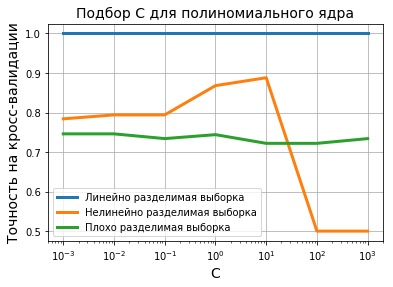

In [523]:
plt.figure()
plt.semilogx(C_values['C'], poly_score[0], label='Линейно разделимая выборка', linewidth=3)
plt.semilogx(C_values['C'], poly_score[1], label='Нелинейно разделимая выборка', linewidth=3)
plt.semilogx(C_values['C'], poly_score[2], label='Плохо разделимая выборка', linewidth=3)
plt.grid()
plt.legend()
plt.xlabel('С', fontsize=14)
plt.ylabel('Точность на кросс-валидации', fontsize=14)
plt.title('Подбор С для полиномиального ядра', fontsize=14)
plt.savefig('SVM_Report/pict18.pdf')

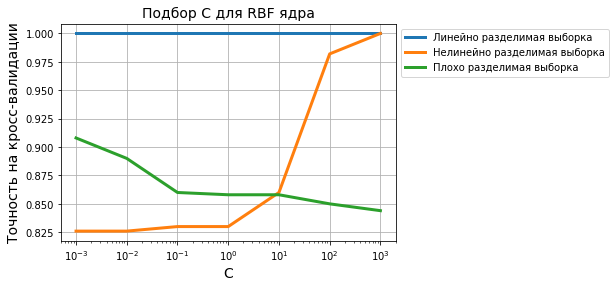

In [524]:
fig = plt.figure()
plt.semilogx(C_values['C'], rbf_score[0], label='Линейно разделимая выборка', linewidth=3)
plt.semilogx(C_values['C'], rbf_score[1], label='Нелинейно разделимая выборка', linewidth=3)
plt.semilogx(C_values['C'], rbf_score[2], label='Плохо разделимая выборка', linewidth=3)
plt.grid()
plt.legend(bbox_to_anchor=(1, 1))
plt.xlabel('С', fontsize=14)
plt.ylabel('Точность на кросс-валидации', fontsize=14)
plt.title('Подбор С для RBF ядра', fontsize=14)
plt.savefig('SVM_Report/pict19.pdf', bbox_inches='tight')

In [533]:
poly_score = []
rbf_score = []
degrees = {'degree':list(np.arange(8) + 1)}
gammas = {'gamma':[1e-4, 1e-3, 1e-2, 1e-1, 0.5, 1, 2, 10]}
for dataset in datasets:
    X, y = create_dataset(complexity=dataset, n_features=2, n_samples=500, random_state=42)
    poly = svm.SVMSolver(C=10, method='dual', kernel='polynomial')
    grid = model_selection.GridSearchCV(poly, degrees, scoring=metrics.make_scorer(metrics.accuracy_score),
                                        n_jobs=-1, cv=4)
    grid.fit(X, y)
    poly_score.append(grid.cv_results_['mean_test_score'])
    rbf = svm.SVMSolver(C=1000, method='dual', kernel='rbf')
    grid = model_selection.GridSearchCV(rbf, gammas, scoring=metrics.make_scorer(metrics.accuracy_score),
                                        n_jobs=-1, cv=3)
    grid.fit(X, y)
    rbf_score.append(grid.cv_results_['mean_test_score'])

     pcost       dcost       gap    pres   dres
 0: -1.0199e+01 -1.3778e+01  1e+03  4e+01  3e-14
     pcost       dcost       gap    pres   dres
 0: -1.0403e+01 -1.3533e+01  1e+03  4e+01  2e-14
 1: -6.8599e-01 -1.3045e+01  4e+01  7e-01  2e-14
     pcost       dcost       gap    pres   dres
 0: -1.1116e+01 -1.3624e+01  1e+03  4e+01  2e-14
 1: -6.7011e-01 -1.3288e+01  4e+01  7e-01  2e-14
     pcost       dcost       gap    pres   dres
 0: -9.7168e+00 -1.3480e+01  1e+03  4e+01  2e-14
 1: -7.3310e-01 -1.3136e+01  4e+01  7e-01  3e-14
 2: -3.2080e-01 -4.6642e+00  6e+00  7e-02  2e-15
 2: -2.9477e-01 -4.8907e+00  6e+00  7e-02  3e-15
 2: -3.2571e-01 -4.8188e+00  6e+00  7e-02  3e-15
 1: -6.3023e-01 -1.2990e+01  4e+01  7e-01  2e-14
 3: -8.4134e-02 -6.9655e-01  8e-01  8e-03  2e-15
 3: -1.0191e-01 -7.4452e-01  8e-01  8e-03  2e-15
 3: -9.0745e-02 -7.2411e-01  8e-01  8e-03  2e-15
 2: -2.8260e-01 -4.4041e+00  6e+00  6e-02  2e-15
 4: -9.4535e-02 -3.3374e-01  3e-01  3e-03  1e-15
 4: -1.1161e-01 -3.3800e

12: -2.5249e-02 -2.6789e-02  2e-03  9e-17  2e-14
12: -1.7231e-02 -2.5579e-02  8e-03  7e-07  8e-15
13: -2.6003e-02 -2.6040e-02  4e-05  1e-16  8e-15
11: -2.9047e-02 -3.5597e-02  2e-02  6e-05  9e-15
13: -2.0679e-02 -2.0885e-02  2e-04  1e-08  9e-15
     pcost       dcost       gap    pres   dres
14: -2.0780e-02 -2.0783e-02  2e-06  1e-10  8e-15
12: -2.5539e-02 -3.1463e-02  1e-02  3e-05  1e-14
Optimal solution found.
 0: -1.8590e+00 -1.2474e+01  1e+03  3e+01  3e-10
14: -2.6017e-02 -2.6017e-02  8e-07  8e-17  1e-14
Optimal solution found.
13: -2.3916e-02 -2.4251e-02  6e-04  1e-06  1e-14
 1: -1.2624e-01 -1.1971e+01  3e+01  5e-01  6e-10
14: -2.3874e-02 -2.3878e-02  6e-06  1e-08  1e-14
Optimal solution found.
 2: -5.9783e-02 -2.8692e+00  4e+00  4e-02  5e-11
     pcost       dcost       gap    pres   dres
 0: -1.5311e+00 -1.1879e+01  1e+03  3e+01  2e-10
     pcost       dcost       gap    pres   dres
 1: -1.1013e-01 -1.1377e+01  3e+01  5e-01  3e-10
 3: -2.8327e-02 -9.8089e-01  1e+00  1e-02  2e-11


 4: -3.4645e-02 -2.2640e-01  3e-01  2e-03  1e-09
13: -3.2851e-03 -6.1933e-03  5e-03  1e-05  5e-13
 5: -5.4233e-03 -4.5505e-02  5e-02  4e-04  4e-10
 5: -3.2755e-02 -1.3295e-01  1e-01  1e-03  5e-10
 6: -1.9333e-02 -9.0626e-02  1e-01  8e-04  3e-10
 6: -2.8644e-03 -2.1026e-02  3e-02  2e-04  2e-10
14: -3.1715e-03 -5.1523e-03  4e-03  8e-06  3e-13
     pcost       dcost       gap    pres   dres
 7: -1.1592e-02 -3.2308e-02  4e-02  3e-04  1e-10
 0: -3.9948e-01 -1.1867e+01  1e+03  3e+01  1e-07
 7: -7.5690e-04 -5.8791e-03  7e-03  4e-05  6e-11
 8: -3.1408e-03 -1.1340e-02  1e-02  6e-05  7e-11
15: -3.0793e-03 -4.2244e-03  3e-03  5e-06  2e-13
 1: -4.1646e-02 -1.1363e+01  3e+01  4e-01  2e-07
 9: -2.1176e-03 -7.2743e-03  8e-03  3e-05  4e-11
16: -2.9467e-03 -3.1012e-03  1e-03  2e-06  9e-14
 8: -4.1190e-04 -2.6695e-03  3e-03  2e-05  2e-11
 2: -2.2100e-02 -2.6033e+00  3e+00  4e-02  1e-08
 9: -3.5209e-04 -2.4315e-03  3e-03  1e-05  2e-11
17: -2.6112e-03 -2.5749e-03  8e-04  1e-06  1e-13
10: -1.7449e-03 -5.81

16: -2.6966e-04 -2.8950e-04  2e-04  3e-07  1e-11
     pcost       dcost       gap    pres   dres
 7: -1.9228e-03 -9.4927e-03  1e-02  8e-05  2e-09
 0: -1.5921e-01 -1.1135e+01  9e+02  3e+01  5e-05
17: -2.4267e-04 -2.7623e-04  2e-04  2e-07  9e-12
 8: -1.4189e-03 -5.9301e-03  7e-03  4e-05  1e-09
 1: -2.8872e-02 -1.0629e+01  2e+01  3e-01  5e-05
18: -2.0899e-04 -2.2942e-04  1e-04  1e-07  6e-12
     pcost       dcost       gap    pres   dres
 0: -9.0528e-02 -1.0514e+01  8e+02  3e+01  3e-05
 2: -2.5719e-02 -2.2583e+00  3e+00  4e-02  5e-06
19: -1.9097e-04 -2.1475e-04  8e-05  6e-08  4e-12
 9: -1.1740e-03 -3.1368e-03  3e-03  2e-05  4e-10
 3: -2.5251e-02 -4.8788e-01  6e-01  6e-03  2e-06
 1: -2.3377e-02 -1.0010e+01  2e+01  3e-01  4e-05
20: -1.8314e-04 -2.0373e-04  6e-05  4e-08  3e-12
10: -1.0524e-03 -2.6790e-03  3e-03  1e-05  3e-10
 4: -1.9172e-02 -2.2525e-01  3e-01  3e-03  7e-07
 2: -2.0959e-02 -2.1951e+00  3e+00  4e-02  5e-06
21: -1.8161e-04 -2.0091e-04  6e-05  4e-08  2e-12
 3: -1.1369e-02 -5.521

 0: -1.2978e+02 -1.7127e+03  2e+03  8e-14  5e-14
 0:  2.1092e+01 -1.9506e+03  5e+03  7e-01  1e-14
 0: -1.4092e+02 -1.9455e+03  2e+03  1e-13  3e-14
 1: -1.5534e+02 -4.2362e+02  3e+02  3e-13  5e-14
 1:  5.2679e+01 -4.1087e+02  5e+02  6e-14  2e-14
 1: -1.6613e+02 -3.5337e+02  2e+02  2e-14  5e-14
 2: -1.8720e+02 -2.7923e+02  9e+01  1e-13  5e-14
 1: -1.5215e+02 -3.9537e+02  2e+02  3e-14  4e-14
 3: -2.0651e+02 -2.3277e+02  3e+01  2e-13  5e-14
 2: -1.2090e+01 -1.0548e+02  9e+01  1e-14  1e-14
 2: -1.8234e+02 -2.7377e+02  9e+01  2e-13  4e-14
 2: -2.1524e+02 -2.5832e+02  4e+01  5e-14  5e-14
 3: -1.6526e+01 -9.9322e+01  8e+01  2e-14  1e-14
 3: -2.2799e+02 -2.4501e+02  2e+01  2e-13  5e-14
 4: -2.1317e+02 -2.2139e+02  8e+00  1e-13  5e-14
 3: -2.0303e+02 -2.1944e+02  2e+01  9e-14  4e-14
 4: -2.5312e+01 -8.1220e+01  6e+01  1e-14  9e-15
 4: -2.0847e+02 -2.1241e+02  4e+00  3e-14  4e-14
 4: -2.3334e+02 -2.3931e+02  6e+00  1e-13  5e-14
 5: -2.1557e+02 -2.1748e+02  2e+00  2e-13  6e-14
 5: -2.0967e+02 -2.1

 0:  2.2707e+01 -1.1769e+03  3e+03  5e-01  9e-16
13: -8.1130e+00 -8.1130e+00  5e-06  2e-15  2e-15
 4: -6.8523e+00 -7.8949e+00  1e+00  4e-07  3e-16
Optimal solution found.
 2: -3.1624e+00 -2.0081e+01  2e+01  9e-15  1e-15
 1:  2.5993e+01 -1.3969e+02  2e+02  4e-04  1e-15
 5: -7.0502e+00 -7.3091e+00  3e-01  6e-08  3e-16
 2: -2.8785e+00 -2.0596e+01  2e+01  1e-05  1e-15
 3: -6.5939e+00 -9.6888e+00  3e+00  4e-15  5e-16
 6: -7.1011e+00 -7.2300e+00  1e-01  1e-08  3e-16
 3: -6.1836e+00 -9.5936e+00  3e+00  2e-06  5e-16
     pcost       dcost       gap    pres   dres
 0:  3.3128e+01 -1.2579e+03  1e+03  3e-15  9e-16
 4: -7.1659e+00 -8.1560e+00  1e+00  4e-15  4e-16
 4: -6.7904e+00 -7.7436e+00  1e+00  4e-07  3e-16
 7: -7.1228e+00 -7.1633e+00  4e-02  3e-09  2e-16
 1: -3.6222e+00 -8.2181e+01  8e+01  9e-15  1e-15
 8: -7.1328e+00 -7.1501e+00  2e-02  2e-10  3e-16
 5: -7.3454e+00 -7.6164e+00  3e-01  3e-15  3e-16
 5: -6.9732e+00 -7.2704e+00  3e-01  6e-08  2e-16
 2: -1.0442e+01 -1.4839e+01  4e+00  3e-15  5e-

     pcost       dcost       gap    pres   dres
 0: -6.4404e+01 -2.0193e+01  2e+03  5e+01  7e-15
     pcost       dcost       gap    pres   dres
     pcost       dcost       gap    pres   dres
 0: -6.8287e+01 -2.0097e+01  2e+03  5e+01  7e-15
 0: -5.9638e+01 -2.0021e+01  2e+03  5e+01  5e-15
 0: -6.4294e+01 -2.0082e+01  2e+03  5e+01  8e-15
 1: -3.9844e+00 -1.9877e+01  4e+01  4e-01  7e-15
 1: -3.7099e+00 -1.9697e+01  4e+01  5e-01  5e-15
 1: -3.9756e+00 -1.9771e+01  4e+01  4e-01  9e-15
 1: -4.1342e+00 -1.9785e+01  4e+01  4e-01  6e-15
 2: -3.4511e+00 -8.4154e+00  5e+00  1e-16  5e-16
 2: -3.1628e+00 -8.2966e+00  5e+00  1e-16  4e-16
 2: -3.4717e+00 -8.3044e+00  5e+00  1e-16  5e-16
 2: -3.5945e+00 -8.3754e+00  5e+00  1e-16  5e-16
 3: -3.9283e+00 -5.0143e+00  1e+00  9e-17  5e-16
 3: -3.9722e+00 -4.9985e+00  1e+00  1e-16  5e-16
 3: -3.6016e+00 -4.8359e+00  1e+00  8e-17  4e-16
 3: -4.0934e+00 -5.0581e+00  1e+00  9e-17  4e-16
 4: -4.2538e+00 -4.4837e+00  2e-01  9e-17  5e-16
 4: -4.2879e+00 -4.5217

 1: -1.1642e+00 -1.2250e+01  4e+01  8e-01  1e-14
 3: -9.6869e-01 -1.5240e+00  6e-01  4e-03  2e-15
 2: -9.4494e-01 -5.7025e+00  6e+00  5e-02  3e-15
 5: -1.1048e+00 -1.1480e+00  4e-02  1e-04  3e-15
 4: -1.0189e+00 -1.1592e+00  1e-01  6e-04  2e-15
 3: -9.7514e-01 -1.4834e+00  5e-01  4e-03  3e-15
 3: -9.8064e-01 -1.6619e+00  7e-01  6e-03  3e-15
 6: -1.1128e+00 -1.1317e+00  2e-02  3e-05  2e-15
 5: -1.0442e+00 -1.0821e+00  4e-02  1e-04  2e-15
 4: -1.0233e+00 -1.2277e+00  2e-01  1e-03  3e-15
 4: -1.0417e+00 -1.1737e+00  1e-01  6e-04  3e-15
 7: -1.1159e+00 -1.1254e+00  9e-03  1e-05  2e-15
 6: -1.0511e+00 -1.0700e+00  2e-02  5e-05  2e-15
 8: -1.1181e+00 -1.1216e+00  3e-03  4e-06  2e-15
 5: -1.0508e+00 -1.1242e+00  7e-02  3e-04  3e-15
 5: -1.0647e+00 -1.1234e+00  6e-02  2e-04  2e-15
 7: -1.0550e+00 -1.0634e+00  8e-03  2e-05  2e-15
 6: -1.0624e+00 -1.0964e+00  3e-02  1e-04  3e-15
 9: -1.1192e+00 -1.1199e+00  7e-04  7e-07  2e-15
 6: -1.0743e+00 -1.1037e+00  3e-02  8e-05  2e-15
10: -1.1194e+00 -1.1

 6: -9.9801e-02 -1.0820e-01  8e-03  3e-06  1e-14
12: -2.1609e-01 -2.1609e-01  3e-06  8e-17  5e-15
 3: -8.0526e-02 -2.9118e-01  2e-01  1e-03  3e-14
11: -2.1985e-01 -2.1993e-01  8e-05  1e-09  5e-15
Optimal solution found.
 4: -8.6064e-02 -2.3172e-01  2e-01  7e-04  2e-14
 7: -1.0114e-01 -1.0285e-01  2e-03  4e-07  1e-14
12: -2.1988e-01 -2.1990e-01  2e-05  1e-10  6e-15
 5: -9.2705e-02 -1.4792e-01  6e-02  2e-04  9e-15
13: -2.1989e-01 -2.1989e-01  1e-06  7e-12  6e-15
Optimal solution found.
 8: -1.0130e-01 -1.0264e-01  1e-03  3e-07  9e-15
 6: -9.5745e-02 -1.2098e-01  3e-02  7e-05  8e-15
 9: -1.0166e-01 -1.0195e-01  3e-04  4e-08  1e-14
 7: -9.8106e-02 -1.0306e-01  5e-03  1e-06  8e-15
     pcost       dcost       gap    pres   dres
10: -1.0172e-01 -1.0187e-01  2e-04  2e-08  1e-14
 0: -1.6121e-01 -1.0511e+01  8e+02  3e+01  5e-13
 8: -9.9046e-02 -1.0000e-01  1e-03  7e-08  1e-14
11: -1.0176e-01 -1.0181e-01  4e-05  3e-09  1e-14
     pcost       dcost       gap    pres   dres
 0: -1.6809e-01 -1.0591

 6: -8.9739e+02 -8.9796e+02  6e-01  2e-15  2e-14
 6: -9.4807e+02 -9.4812e+02  6e-02  3e-15  3e-14
 7: -9.4810e+02 -9.4810e+02  4e-03  8e-15  3e-14
 7: -8.9762e+02 -8.9779e+02  2e-01  4e-14  2e-14
 9: -9.1705e+02 -9.1705e+02  1e-04  2e-16  4e-14
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -4.6449e+02 -2.1955e+03  2e+03  3e-15  1e-14
 8: -9.4810e+02 -9.4810e+02  2e-04  2e-14  3e-14
Optimal solution found.
 8: -8.9767e+02 -8.9775e+02  8e-02  1e-14  2e-14
 1: -5.3715e+02 -7.3058e+02  2e+02  1e-14  1e-14
 9: -8.9770e+02 -8.9772e+02  2e-02  4e-15  1e-14
     pcost       dcost       gap    pres   dres
 0: -4.9282e+02 -2.1750e+03  2e+03  1e-14  2e-14
 2: -6.0369e+02 -6.3489e+02  3e+01  1e-14  1e-14
10: -8.9771e+02 -8.9772e+02  1e-03  4e-15  2e-14
     pcost       dcost       gap    pres   dres
 0: -2.1951e+02 -2.0425e+03  2e+03  5e-15  1e-14
 1: -5.7772e+02 -7.6314e+02  2e+02  2e-14  3e-14
 3: -6.1756e+02 -6.2517e+02  8e+00  2e-14  1e-14
11: -8.9772e+02 -8.9772e

Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.6890e+01 -1.4112e+03  3e+03  5e-01  2e-15
     pcost       dcost       gap    pres   dres
 0:  2.7837e+01 -1.3102e+03  3e+03  5e-01  1e-15
 4: -1.4651e+01 -1.7688e+01  3e+00  3e-15  1e-15
 1:  3.7588e+01 -1.8182e+02  2e+02  5e-15  1e-15
 5: -1.5085e+01 -1.6537e+01  1e+00  6e-15  1e-15
 1:  3.6225e+01 -2.1569e+02  3e+02  9e-16  2e-15
     pcost       dcost       gap    pres   dres
 0:  2.6872e+01 -1.2807e+03  3e+03  5e-01  1e-15
 2: -2.5257e+00 -2.3453e+01  2e+01  2e-15  1e-15
 6: -1.5365e+01 -1.5645e+01  3e-01  7e-15  1e-15
 1:  3.5619e+01 -1.7365e+02  2e+02  2e-15  1e-15
 2: -6.8731e+00 -4.1692e+01  3e+01  2e-15  2e-15
 3: -6.4206e+00 -1.2959e+01  7e+00  2e-15  6e-16
 7: -1.5416e+01 -1.5605e+01  2e-01  1e-15  1e-15
 2: -2.1967e+00 -2.7040e+01  2e+01  9e-16  1e-15
 3: -1.3082e+01 -2.1804e+01  9e+00  2e-16  1e-15
 4: -7.6366e+00 -9.2294e+00  2e+00  7e-16  7e-16
 8: -1.5477e+01 -1.5517e+01  4e-02  2e-16  1e-15

 7: -2.1695e+00 -2.1905e+00  2e-02  4e-05  1e-15
 6: -2.5334e+00 -2.6738e+00  1e-01  4e-04  1e-15
 8: -2.7587e+00 -2.7680e+00  1e-02  2e-05  2e-15
 7: -2.3537e+00 -2.3776e+00  2e-02  7e-05  2e-15
 8: -2.1769e+00 -2.1816e+00  5e-03  7e-06  2e-15
 9: -2.7624e+00 -2.7638e+00  1e-03  1e-06  2e-15
 7: -2.5747e+00 -2.6200e+00  5e-02  1e-04  1e-15
 9: -2.1787e+00 -2.1795e+00  8e-04  4e-07  2e-15
 8: -2.3635e+00 -2.3664e+00  3e-03  3e-06  2e-15
10: -2.1791e+00 -2.1791e+00  2e-05  1e-08  2e-15
10: -2.7631e+00 -2.7631e+00  2e-05  2e-08  2e-15
 8: -2.5882e+00 -2.6029e+00  2e-02  3e-05  1e-15
11: -2.7631e+00 -2.7631e+00  2e-07  2e-10  2e-15
Optimal solution found.
11: -2.1791e+00 -2.1791e+00  5e-07  2e-10  2e-15
Optimal solution found.
 9: -2.5935e+00 -2.5963e+00  3e-03  5e-06  1e-15
 9: -2.3648e+00 -2.3650e+00  2e-04  1e-07  2e-15
     pcost       dcost       gap    pres   dres
 0: -5.4744e+01 -2.3001e+01  3e+03  6e+01  2e-13
10: -2.5946e+00 -2.5950e+00  4e-04  6e-07  1e-15
     pcost       dcost

 7: -1.8561e+00 -2.1422e+00  4e-01  2e-03  3e-13
 7: -1.1191e+00 -1.4722e+00  5e-01  3e-03  4e-13
 9: -1.3197e+00 -1.4188e+00  1e-01  5e-04  2e-13
     pcost       dcost       gap    pres   dres
 0: -4.6536e+01 -2.1339e+01  3e+03  6e+01  5e-11
 8: -1.8567e+00 -2.0787e+00  3e-01  1e-03  4e-13
10: -1.3214e+00 -1.3880e+00  9e-02  3e-04  2e-13
 1: -2.4248e+00 -2.0892e+01  7e+01  9e-01  6e-11
 8: -1.1140e+00 -1.4015e+00  4e-01  2e-03  3e-13
 9: -1.8662e+00 -2.0121e+00  2e-01  6e-04  3e-13
11: -1.3238e+00 -1.3530e+00  5e-02  1e-04  1e-13
 2: -1.7479e+00 -1.1262e+01  2e+01  2e-01  1e-11
12: -1.3187e+00 -1.3353e+00  2e-02  3e-05  2e-13
 9: -1.1167e+00 -1.2953e+00  2e-01  9e-04  3e-13
 3: -1.4902e+00 -5.0915e+00  5e+00  4e-02  4e-12
10: -1.8803e+00 -1.9371e+00  7e-02  2e-04  3e-13
13: -1.3192e+00 -1.3276e+00  9e-03  8e-07  2e-13
 4: -1.4560e+00 -3.5826e+00  3e+00  2e-02  2e-12
10: -1.1149e+00 -1.2136e+00  1e-01  3e-04  2e-13
11: -1.8864e+00 -1.9055e+00  2e-02  5e-05  3e-13
 5: -1.4913e+00 -2.28

13: -1.8023e+00 -1.8098e+00  8e-03  9e-06  3e-11
     pcost       dcost       gap    pres   dres
 0: -4.1434e+01 -2.1212e+01  3e+03  6e+01  8e-09
 8: -1.0126e+00 -1.2489e+00  3e-01  1e-03  5e-11
14: -1.8034e+00 -1.8072e+00  4e-03  3e-06  3e-11
15: -1.2204e+00 -1.2314e+00  1e-02  5e-06  9e-12
 1: -2.1057e+00 -2.0755e+01  6e+01  8e-01  8e-09
 9: -1.0089e+00 -1.1968e+00  3e-01  1e-03  3e-11
16: -1.2217e+00 -1.2283e+00  7e-03  7e-07  8e-12
 2: -1.5245e+00 -9.7423e+00  1e+01  1e-01  1e-09
15: -1.8042e+00 -1.8056e+00  1e-03  1e-06  2e-11
10: -1.0002e+00 -1.1559e+00  2e-01  7e-04  5e-11
 3: -1.4066e+00 -5.2789e+00  5e+00  4e-02  5e-10
16: -1.8045e+00 -1.8050e+00  5e-04  2e-08  3e-11
17: -1.2238e+00 -1.2250e+00  1e-03  7e-08  1e-11
11: -9.9753e-01 -1.1286e+00  2e-01  6e-04  2e-11
17: -1.8047e+00 -1.8047e+00  9e-06  3e-10  2e-11
Optimal solution found.
18: -1.2243e+00 -1.2243e+00  8e-05  4e-09  1e-11
 4: -1.4332e+00 -2.5380e+00  1e+00  1e-02  2e-10
12: -9.8030e-01 -1.1012e+00  2e-01  4e-04  3e-

14: -1.3930e+00 -1.4320e+00  5e-02  4e-05  2e-10
 7: -1.1495e+00 -1.3865e+00  3e-01  1e-03  2e-08
 5: -1.6727e+00 -2.4532e+00  1e+00  4e-03  5e-08
24: -9.0638e-01 -9.0913e-01  4e-03  4e-07  1e-10
 8: -1.1540e+00 -1.3255e+00  2e-01  6e-04  7e-09
15: -1.3929e+00 -1.4277e+00  4e-02  3e-05  1e-10
 9: -1.1518e+00 -1.3038e+00  2e-01  5e-04  6e-09
25: -9.0699e-01 -9.0748e-01  5e-04  1e-08  2e-10
 6: -1.6724e+00 -2.3541e+00  8e-01  3e-03  3e-08
16: -1.3939e+00 -1.4177e+00  3e-02  2e-05  1e-10
26: -9.0720e-01 -9.0721e-01  8e-06  2e-10  3e-10
Optimal solution found.
 7: -1.6899e+00 -2.1524e+00  6e-01  2e-03  2e-08
10: -1.1532e+00 -1.2580e+00  1e-01  3e-04  4e-09
17: -1.3942e+00 -1.4102e+00  2e-02  1e-05  1e-10
 8: -1.6910e+00 -2.0807e+00  5e-01  1e-03  1e-08
11: -1.1511e+00 -1.2353e+00  1e-01  2e-04  3e-09
18: -1.3941e+00 -1.4046e+00  2e-02  7e-06  2e-10
19: -1.3921e+00 -1.4009e+00  1e-02  1e-06  1e-10
12: -1.1498e+00 -1.2145e+00  9e-02  1e-04  2e-09
 9: -1.7047e+00 -1.9325e+00  3e-01  7e-04  7e

 2: -7.5781e+02 -8.1049e+02  5e+01  2e-13  1e-13
 3: -3.2440e+02 -3.9867e+02  7e+01  6e-14  6e-14
 4: -4.8061e+02 -4.8271e+02  2e+00  1e-13  7e-14
 3: -7.8806e+02 -8.0229e+02  1e+01  4e-14  1e-13
 3: -4.6906e+02 -5.0072e+02  3e+01  9e-15  5e-14
 4: -3.4093e+02 -3.7522e+02  3e+01  1e-13  6e-14
 5: -4.8152e+02 -4.8186e+02  3e-01  2e-13  7e-14
 5: -3.4724e+02 -3.6623e+02  2e+01  1e-13  5e-14
 4: -7.9431e+02 -8.0002e+02  6e+00  2e-13  1e-13
 4: -4.7754e+02 -4.8581e+02  8e+00  1e-13  5e-14
 6: -4.8166e+02 -4.8172e+02  7e-02  3e-13  7e-14
 6: -3.5053e+02 -3.6147e+02  1e+01  9e-14  6e-14
 5: -4.7982e+02 -4.8311e+02  3e+00  1e-13  5e-14
 5: -7.9779e+02 -7.9787e+02  8e-02  7e-14  1e-13
 7: -4.8168e+02 -4.8170e+02  1e-02  1e-13  7e-14
 6: -4.8084e+02 -4.8198e+02  1e+00  3e-13  5e-14
 7: -3.5361e+02 -3.5712e+02  4e+00  1e-13  6e-14
 6: -7.9784e+02 -7.9784e+02  8e-04  3e-13  1e-13
Optimal solution found.
 8: -4.8169e+02 -4.8169e+02  5e-04  5e-14  7e-14
 7: -4.8115e+02 -4.8164e+02  5e-01  1e-13  5e

10: -1.3301e+02 -1.3301e+02  4e-03  2e-14  6e-15
 8: -1.6590e+02 -1.6630e+02  4e-01  8e-07  8e-15
 5: -1.2649e+02 -1.3544e+02  9e+00  1e-13  4e-15
11: -1.3301e+02 -1.3301e+02  3e-04  2e-14  7e-15
 9: -1.6602e+02 -1.6611e+02  9e-02  1e-07  9e-15
 8: -1.2688e+02 -1.2724e+02  4e-01  2e-09  5e-15
 6: -1.2808e+02 -1.2985e+02  2e+00  1e-13  4e-15
12: -1.3301e+02 -1.3301e+02  4e-06  4e-15  6e-15
10: -1.6605e+02 -1.6606e+02  1e-02  7e-09  9e-15
Optimal solution found.
 9: -1.2698e+02 -1.2706e+02  8e-02  4e-10  5e-15
 7: -1.2836e+02 -1.2914e+02  8e-01  9e-15  4e-15
11: -1.6605e+02 -1.6606e+02  3e-04  1e-10  9e-15
10: -1.2701e+02 -1.2702e+02  1e-02  1e-11  5e-15
11: -1.2701e+02 -1.2701e+02  8e-04  8e-13  5e-15
12: -1.6606e+02 -1.6606e+02  4e-06  1e-12  9e-15
Optimal solution found.
 8: -1.2851e+02 -1.2871e+02  2e-01  3e-15  5e-15
     pcost       dcost       gap    pres   dres
12: -1.2701e+02 -1.2701e+02  9e-06  9e-15  5e-15
Optimal solution found.
 0: -9.1806e+01 -2.3426e+03  6e+03  8e-01  4e-1

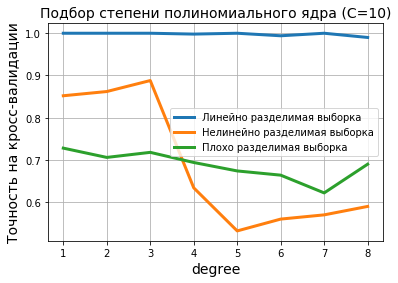

In [536]:
plt.figure()
plt.plot(degrees['degree'], poly_score[0], label='Линейно разделимая выборка', linewidth=3)
plt.plot(degrees['degree'], poly_score[1], label='Нелинейно разделимая выборка', linewidth=3)
plt.plot(degrees['degree'], poly_score[2], label='Плохо разделимая выборка', linewidth=3)
plt.grid()
plt.legend()
plt.xlabel('degree', fontsize=14)
plt.ylabel('Точность на кросс-валидации', fontsize=14)
plt.title('Подбор степени полиномиального ядра (C=10)', fontsize=14)
plt.savefig('SVM_Report/pict20.pdf')

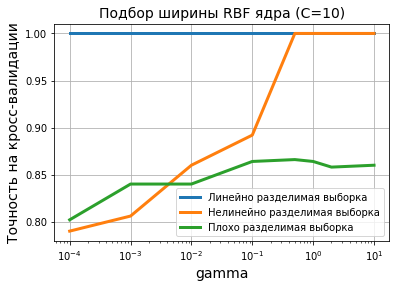

In [537]:
fig = plt.figure()
plt.semilogx(gammas['gamma'], rbf_score[0], label='Линейно разделимая выборка', linewidth=3)
plt.semilogx(gammas['gamma'], rbf_score[1], label='Нелинейно разделимая выборка', linewidth=3)
plt.semilogx(gammas['gamma'], rbf_score[2], label='Плохо разделимая выборка', linewidth=3)
plt.grid()
#plt.legend(bbox_to_anchor=(1, 1))
plt.legend()
plt.xlabel('gamma', fontsize=14)
plt.ylabel('Точность на кросс-валидации', fontsize=14)
plt.title('Подбор ширины RBF ядра (C=10)', fontsize=14)
plt.savefig('SVM_Report/pict21.pdf', bbox_inches='tight')

In [548]:
poly_score = []
rbf_score = []
degrees = {'degree':list(np.arange(8) + 1)}
gammas = {'gamma':[1e-4, 1e-3, 1e-2, 1e-1, 0.5, 1, 2, 10]}
for dataset in datasets:
    X, y = create_dataset(complexity=dataset, n_features=2, n_samples=500, random_state=42)
    poly = svm.SVMSolver(C=1e-3, method='dual', kernel='polynomial')
    grid = model_selection.GridSearchCV(poly, degrees, scoring=metrics.make_scorer(metrics.accuracy_score),
                                        n_jobs=-1, cv=4)
    grid.fit(X, y)
    poly_score.append(grid.cv_results_['mean_test_score'])

    rbf = svm.SVMSolver(C=1e-3, method='dual', kernel='rbf')
    grid = model_selection.GridSearchCV(rbf, gammas, scoring=metrics.make_scorer(metrics.accuracy_score),
                                        n_jobs=-1, cv=3)
    grid.fit(X, y)
    rbf_score.append(grid.cv_results_['mean_test_score'])

     pcost       dcost       gap    pres   dres
     pcost       dcost       gap    pres   dres
     pcost       dcost       gap    pres   dres
 0: -9.7350e+00 -2.6257e-02  2e+03  4e+01  3e-14
     pcost       dcost       gap    pres   dres
 0: -1.0390e+01 -2.5782e-02  2e+03  4e+01  2e-14
 0: -9.6765e+00 -2.6109e-02  2e+03  4e+01  3e-14
 0: -9.3425e+00 -2.6226e-02  1e+03  4e+01  2e-14
 1: -1.2383e-01 -2.6225e-02  2e+01  4e-01  3e-14
 1: -1.2957e-01 -2.5753e-02  2e+01  4e-01  2e-14
 1: -1.1997e-01 -2.6193e-02  1e+01  4e-01  3e-14
 2: -2.7226e-02 -2.3447e-02  4e-01  1e-02  1e-15
 1: -1.2272e-01 -2.6078e-02  2e+01  4e-01  2e-14
 3: -8.2785e-03 -2.8386e-03  5e-02  1e-03  7e-16
 2: -2.6913e-02 -2.3352e-02  4e-01  1e-02  7e-16
 2: -2.6763e-02 -2.3085e-02  4e-01  1e-02  8e-16
 2: -2.7250e-02 -2.3370e-02  4e-01  1e-02  9e-16
 4: -7.5461e-04 -2.0413e-03  2e-03  1e-05  2e-15
 3: -6.9992e-03 -2.6264e-03  4e-02  9e-04  6e-16
 3: -6.4937e-03 -2.5425e-03  3e-02  8e-04  7e-16
 3: -7.5828e-03 -2.5969e

 2: -1.9106e-02 -9.7283e-03  1e+00  4e-02  5e-10
     pcost       dcost       gap    pres   dres
 8: -1.2217e-04 -1.3271e-04  1e-05  8e-08  1e-15
 0: -9.1779e-01 -2.0651e-02  1e+03  4e+01  3e-09
 3: -9.1547e-04 -1.6467e-03  5e-02  1e-03  4e-11
 1: -2.9258e-02 -2.2106e-02  1e+01  4e-01  5e-09
 9: -1.2315e-04 -1.3040e-04  8e-06  4e-08  1e-15
 4: -1.7526e-04 -1.4476e-03  4e-03  8e-05  3e-12
Optimal solution found.
 1: -2.9927e-02 -2.0339e-02  2e+01  4e-01  3e-09
 2: -1.8948e-02 -1.0204e-02  1e+00  3e-02  4e-10
 5: -1.1022e-04 -9.5680e-04  2e-03  3e-05  9e-13
 2: -1.7299e-02 -8.9276e-03  2e+00  4e-02  3e-10
 3: -7.3642e-04 -1.4251e-03  5e-02  1e-03  5e-11
 6: -9.3779e-05 -6.6129e-04  1e-03  1e-05  5e-13
 3: -8.7170e-04 -1.7522e-03  8e-02  2e-03  6e-11
     pcost       dcost       gap    pres   dres
 7: -9.2261e-05 -4.3597e-04  6e-04  7e-06  3e-13
 4: -1.9964e-04 -1.4966e-03  7e-03  1e-04  5e-12
 0: -1.0054e+00 -2.3914e-02  1e+03  4e+01  3e-09
 8: -9.0437e-05 -1.9173e-04  2e-04  2e-06  6e-1

19: -3.2364e-05 -4.9338e-05  4e-05  8e-08  8e-14
 2: -1.4083e-02 -4.4320e-03  1e+00  4e-02  3e-07
 1: -3.0788e-02 -2.2335e-02  2e+01  6e-01  3e-06
 4: -9.4447e-05 -1.1618e-03  3e-03  7e-05  5e-09
 2: -1.2216e-02 -4.1148e-03  2e+00  5e-02  2e-07
 3: -1.1286e-03 -1.4852e-03  7e-02  2e-03  7e-08
20: -2.8727e-05 -4.5211e-05  3e-05  5e-08  5e-14
 5: -6.8928e-05 -5.7365e-04  8e-04  1e-05  1e-09
 3: -1.1795e-03 -1.4944e-03  9e-02  2e-03  1e-07
 6: -6.4802e-05 -3.0576e-04  4e-04  6e-06  4e-10
 4: -9.5688e-05 -1.3301e-03  3e-03  5e-05  5e-09
21: -2.8680e-05 -3.0360e-05  3e-06  3e-09  2e-14
Optimal solution found.
 5: -7.4004e-05 -6.3353e-04  1e-03  1e-05  1e-09
 4: -1.1563e-04 -1.3066e-03  5e-03  1e-04  6e-09
 7: -5.9495e-05 -1.4987e-04  2e-04  2e-06  2e-10
 5: -6.6338e-05 -7.1800e-04  1e-03  2e-05  1e-09
 8: -5.1551e-05 -1.0845e-04  1e-04  2e-06  1e-10
 6: -6.4648e-05 -3.2354e-04  4e-04  6e-06  5e-10
 6: -5.3108e-05 -3.8644e-04  6e-04  9e-06  5e-10
 9: -4.3852e-05 -7.5000e-05  7e-05  9e-07  7e

     pcost       dcost       gap    pres   dres
 0: -7.4906e+01 -1.2630e+01  2e+03  4e+01  1e-14
     pcost       dcost       gap    pres   dres
     pcost       dcost       gap    pres   dres
 0: -2.0475e+01 -8.7042e+00  2e+03  4e+01  3e-15
 0: -7.4792e+01 -1.2851e+01  2e+03  4e+01  1e-14
     pcost       dcost       gap    pres   dres
 0: -8.6238e+01 -1.8763e+01  1e+03  4e+01  1e-14
 1: -8.7262e+00 -1.5183e-01  7e+01  2e+00  9e-15
 1: -1.1069e+01 -4.1287e+00  1e+02  3e+00  3e-15
 1: -8.9121e+00 -1.6266e-01  7e+01  2e+00  9e-15
 2:  1.3546e-01 -2.3050e-03  5e+00  1e-01  2e-15
 1: -1.6558e+01 -5.6460e-01  7e+01  2e+00  1e-14
 2: -8.9060e-02 -2.1028e-03  7e-01  2e-02  2e-15
 2: -9.1228e-02 -2.0590e-03  7e-01  2e-02  2e-15
 3:  9.6305e-04 -2.0683e-03  6e-02  1e-03  5e-16
 2: -1.7080e-01 -2.0977e-03  7e-01  2e-02  3e-15
 3: -1.5284e-03 -2.0342e-03  9e-03  2e-04  1e-15
 3: -1.4971e-03 -2.0790e-03  1e-02  2e-04  1e-15
 3: -2.4300e-03 -2.0383e-03  7e-03  2e-04  1e-15
 4: -3.9649e-04 -1.9414e

 5: -9.5215e-04 -1.0277e-03  8e-05  3e-07  3e-16
 6: -4.9796e-04 -5.0250e-04  5e-06  1e-19  4e-16
     pcost       dcost       gap    pres   dres
Optimal solution found.
 0: -1.3331e+01 -7.5177e+00  1e+03  4e+01  3e-16
 6: -9.9672e-04 -1.0013e-03  5e-06  2e-08  3e-16
Optimal solution found.
 1: -8.6633e+00 -3.5186e+00  1e+02  3e+00  4e-16
 2: -1.8296e+00 -1.3295e-01  2e+01  4e-01  7e-16
     pcost       dcost       gap    pres   dres
 0: -3.5181e+01 -1.3576e+01  1e+03  4e+01  2e-16
     pcost       dcost       gap    pres   dres
 0: -3.3573e+01 -1.3306e+01  1e+03  4e+01  2e-16
 3: -2.2619e-02 -1.9329e-03  2e-01  6e-03  1e-15
     pcost       dcost       gap    pres   dres
 0: -4.0252e+01 -1.7073e+01  1e+03  3e+01  2e-16
 1: -1.5364e+01 -2.5669e+00  1e+02  4e+00  4e-16
 4: -7.8271e-04 -1.8864e-03  4e-03  7e-05  8e-16
 1: -1.5055e+01 -2.7489e+00  1e+02  4e+00  4e-16
 2: -1.0529e-01 -2.7373e-03  3e+00  8e-02  1e-15
 5: -4.9517e-04 -1.0046e-03  5e-04  2e-19  9e-16
 2: -1.2416e-01 -2.9949e-

 1: -1.1055e+00 -7.9918e-01  4e+01  1e+00  8e-15
 0: -1.6397e+00 -1.0406e+00  1e+03  3e+01  1e-14
 0: -1.6128e+00 -1.0369e+00  1e+03  3e+01  8e-15
 2: -4.9723e-01 -1.7399e-01  4e+00  1e-01  4e-15
 1: -1.1170e+00 -8.0936e-01  4e+01  1e+00  1e-14
 2: -4.5522e-01 -1.5545e-01  5e+00  1e-01  3e-15
 1: -1.1217e+00 -8.1081e-01  4e+01  1e+00  1e-14
 3: -7.9827e-02 -1.4290e-02  4e-01  1e-02  2e-15
 2: -4.7697e-01 -1.7882e-01  4e+00  1e-01  5e-15
 3: -7.0077e-02 -1.3939e-02  5e-01  1e-02  2e-15
 2: -4.8682e-01 -1.7876e-01  5e+00  1e-01  4e-15
 4: -1.0563e-02 -2.9055e-03  4e-02  1e-03  2e-15
 3: -8.5824e-02 -1.6108e-02  5e-01  1e-02  2e-15
 4: -1.0865e-02 -3.3258e-03  5e-02  1e-03  1e-15
 3: -8.5775e-02 -1.5555e-02  5e-01  1e-02  2e-15
 5: -9.5213e-04 -1.9459e-03  2e-03  2e-05  2e-15
 4: -1.1545e-02 -2.9708e-03  4e-02  1e-03  2e-15
 5: -1.1865e-03 -1.9648e-03  4e-03  7e-05  1e-15
 4: -1.0917e-02 -2.9680e-03  4e-02  1e-03  2e-15
 5: -9.6722e-04 -1.9576e-03  2e-03  3e-05  2e-15
 6: -9.0256e-04 -1.0

 0: -7.9871e-02 -5.7609e-02  8e+02  3e+01  2e-12
     pcost       dcost       gap    pres   dres
 0: -7.6618e-02 -5.5862e-02  8e+02  3e+01  1e-12
 1: -5.9073e-02 -4.6415e-02  2e+01  6e-01  7e-13
 1: -5.7101e-02 -4.5366e-02  2e+01  6e-01  8e-13
 2: -3.8154e-02 -3.0706e-02  1e+00  4e-02  6e-13
 2: -3.7697e-02 -3.0094e-02  1e+00  4e-02  9e-13
     pcost       dcost       gap    pres   dres
 3: -2.2519e-02 -9.2130e-03  1e-01  5e-03  8e-14
 0: -7.4454e-02 -5.4467e-02  8e+02  3e+01  1e-12
     pcost       dcost       gap    pres   dres
 0: -7.7491e-02 -5.6004e-02  8e+02  3e+01  2e-12
 4: -3.7800e-03 -1.8784e-03  2e-02  6e-04  2e-14
 1: -5.7361e-02 -4.5067e-02  2e+01  6e-01  1e-12
 3: -2.1810e-02 -8.6507e-03  2e-01  6e-03  2e-13
 1: -5.5496e-02 -4.4423e-02  2e+01  6e-01  8e-13
 5: -8.7150e-04 -1.5489e-03  2e-03  4e-05  2e-15
 2: -3.7711e-02 -3.0422e-02  1e+00  4e-02  4e-13
 6: -6.9678e-04 -1.0238e-03  4e-04  6e-06  8e-16
 2: -3.7560e-02 -3.0347e-02  1e+00  4e-02  7e-13
 3: -2.2673e-02 -9.8361

     pcost       dcost       gap    pres   dres
 1: -9.1022e+00 -3.0038e+00  9e+01  2e+00  9e-16
 2: -1.6812e+00 -2.6261e-01  7e+00  2e-01  2e-15
 0: -1.0806e+01 -5.9446e+00  1e+03  4e+01  4e-16
 2: -1.6500e+00 -2.8018e-01  8e+00  2e-01  1e-15
 3: -2.0121e-02 -2.2676e-03  2e-01  4e-03  2e-15
 2: -1.7029e+00 -2.5614e-01  7e+00  2e-01  1e-15
 3: -2.4523e-02 -2.3128e-03  2e-01  5e-03  2e-15
 1: -6.6412e+00 -3.3274e+00  7e+01  2e+00  6e-16
 3: -2.2031e-02 -2.2623e-03  2e-01  4e-03  2e-15
 4: -9.4824e-04 -2.2461e-03  3e-03  3e-05  8e-16
 2: -1.7230e+00 -3.0479e-01  7e+00  2e-01  1e-15
 4: -8.8845e-04 -2.2135e-03  2e-03  2e-05  7e-16
 3: -1.7223e-02 -2.1607e-03  1e-01  4e-03  2e-15
 5: -8.6584e-04 -1.1434e-03  3e-04  2e-07  4e-16
 4: -9.2510e-04 -2.2053e-03  2e-03  2e-05  9e-16
 4: -8.6498e-04 -2.1144e-03  2e-03  2e-05  6e-16
 6: -9.3016e-04 -9.6471e-04  3e-05  2e-08  4e-16
 5: -9.0225e-04 -1.1433e-03  3e-04  2e-06  3e-16
 5: -8.8806e-04 -1.1276e-03  3e-04  1e-06  3e-16
 6: -9.4692e-04 -9.79

 6: -6.5743e-04 -7.0324e-04  5e-05  5e-19  5e-16
 5: -6.4851e-04 -2.4112e-03  2e-03  4e-06  1e-15
 3: -1.3725e-02 -6.1552e-03  2e-01  3e-03  2e-15
 3: -1.2600e-02 -6.2194e-03  2e-01  3e-03  1e-15
 7: -6.5883e-04 -6.9339e-04  3e-05  1e-19  3e-16
 4: -9.1090e-04 -2.4186e-03  1e-02  2e-04  1e-15
 6: -6.4363e-04 -1.2071e-03  6e-04  1e-06  5e-16
 4: -8.4563e-04 -2.6483e-03  2e-02  2e-04  1e-15
 7: -6.5567e-04 -7.1241e-04  6e-05  6e-08  3e-16
 5: -5.8766e-04 -1.9173e-03  1e-03  4e-20  5e-16
 8: -6.6271e-04 -6.6894e-04  6e-06  3e-19  3e-16
Optimal solution found.
 5: -5.6853e-04 -2.0958e-03  2e-03  3e-19  5e-16
 8: -6.5777e-04 -6.9801e-04  4e-05  3e-08  2e-16
 6: -6.3679e-04 -9.0834e-04  3e-04  5e-19  5e-16
 7: -6.6034e-04 -6.8012e-04  2e-05  6e-19  5e-16
 6: -6.1833e-04 -1.1208e-03  5e-04  7e-20  4e-16
 9: -6.6263e-04 -6.6909e-04  6e-06  4e-09  3e-16
Optimal solution found.
 7: -6.5825e-04 -6.9613e-04  4e-05  1e-19  5e-16
     pcost       dcost       gap    pres   dres
 8: -6.6117e-04 -6.708

 1: -4.3195e-01 -2.4255e-02  3e+01  6e-01  6e-09
 8: -2.5290e-04 -4.8617e-04  3e-04  2e-06  3e-15
 9: -2.5479e-04 -3.4089e-04  1e-04  6e-07  2e-15
13: -2.3753e-04 -2.4719e-04  1e-05  4e-08  1e-15
 2: -3.0513e-02 -7.6409e-03  1e+00  2e-02  3e-10
10: -2.5919e-04 -3.1151e-04  6e-05  3e-07  2e-15
     pcost       dcost       gap    pres   dres
14: -2.3843e-04 -2.4469e-04  7e-06  2e-08  1e-15
Optimal solution found.
 0: -3.3094e+01 -2.5201e-02  3e+03  6e+01  1e-08
11: -2.6322e-04 -2.8381e-04  2e-05  9e-08  2e-15
 3: -4.0657e-03 -2.9376e-03  1e-01  2e-03  9e-11
 1: -4.0478e-01 -2.4047e-02  4e+01  6e-01  1e-08
12: -2.6449e-04 -2.7947e-04  2e-05  5e-08  2e-15
 4: -7.8716e-04 -2.2972e-03  8e-03  1e-04  8e-12
 2: -2.5504e-02 -6.9720e-03  1e+00  2e-02  5e-10
13: -2.6609e-04 -2.7434e-04  9e-06  3e-08  1e-15
Optimal solution found.
 3: -2.8622e-03 -2.9700e-03  6e-02  1e-03  4e-11
 5: -5.5874e-04 -1.7841e-03  4e-03  5e-05  3e-12
 6: -3.8269e-04 -1.2207e-03  2e-03  2e-05  1e-12
     pcost       dcost

     pcost       dcost       gap    pres   dres
 2: -1.7885e-02 -4.4192e-03  1e+00  2e-02  1e-07
 0: -3.0022e+01 -1.2447e-02  3e+03  5e+01  3e-06
 1: -3.8365e-01 -2.1116e-02  4e+01  7e-01  4e-06
18: -1.8044e-04 -1.8962e-04  1e-05  5e-09  5e-14
Optimal solution found.
 3: -1.3572e-03 -2.3818e-03  4e-02  7e-04  1e-08
 1: -3.4501e-01 -1.1572e-02  3e+01  6e-01  2e-06
 2: -1.9306e-02 -4.3527e-03  1e+00  2e-02  1e-07
 2: -1.1809e-02 -2.7694e-03  8e-01  2e-02  6e-08
 4: -3.9310e-04 -2.0025e-03  5e-03  7e-05  2e-09
 3: -2.2235e-03 -2.5919e-03  8e-02  1e-03  2e-08
 3: -1.1959e-03 -2.1623e-03  6e-02  1e-03  7e-09
 5: -2.6264e-04 -1.3604e-03  2e-03  2e-05  4e-10
 4: -5.2504e-04 -2.1031e-03  8e-03  1e-04  2e-09
 4: -2.7053e-04 -1.9236e-03  7e-03  1e-04  2e-09
     pcost       dcost       gap    pres   dres
 6: -2.1547e-04 -6.9834e-04  7e-04  6e-06  2e-10
 0: -3.6902e+01 -5.6940e-03  3e+03  5e+01  4e-06
 5: -2.8725e-04 -1.5016e-03  2e-03  3e-05  4e-10
 7: -2.0571e-04 -4.8870e-04  4e-04  3e-06  8e-1

 2: -5.4089e-01 -1.6171e-02  9e+00  2e-01  1e-15
 1: -3.0651e+00 -1.4183e+00  7e+01  1e+00  3e-15
 1: -3.3315e+00 -1.4717e+00  7e+01  2e+00  3e-15
 1: -3.1621e+00 -1.5542e+00  8e+01  2e+00  3e-15
 2: -5.7616e-01 -5.2963e-02  7e+00  1e-01  8e-16
 2: -6.4489e-01 -5.6842e-02  8e+00  2e-01  9e-16
 2: -9.2153e-01 -1.3229e-01  6e+00  1e-01  8e-16
 3: -6.2094e-03 -2.2199e-03  9e-02  2e-03  7e-16
 3: -7.1250e-03 -2.3181e-03  9e-02  2e-03  1e-15
 3: -7.8530e-03 -2.4825e-03  1e-01  2e-03  1e-15
 4: -6.0329e-04 -2.1329e-03  3e-03  3e-05  7e-16
 4: -6.2175e-04 -2.2146e-03  3e-03  3e-05  1e-15
 3: -1.0717e-02 -2.7322e-03  7e-02  1e-03  3e-15
 4: -6.0439e-04 -2.3919e-03  3e-03  3e-05  9e-16
 5: -4.9409e-04 -7.8455e-04  3e-04  2e-20  1e-15
 4: -8.4356e-04 -2.6218e-03  2e-03  3e-18  1e-15
 5: -4.8745e-04 -8.2507e-04  3e-04  1e-19  9e-16
 5: -4.9438e-04 -7.7951e-04  3e-04  2e-07  1e-15
 6: -5.0236e-04 -5.0663e-04  4e-06  1e-19  5e-16
Optimal solution found.
 5: -9.1760e-04 -1.2104e-03  3e-04  6e-20  6e

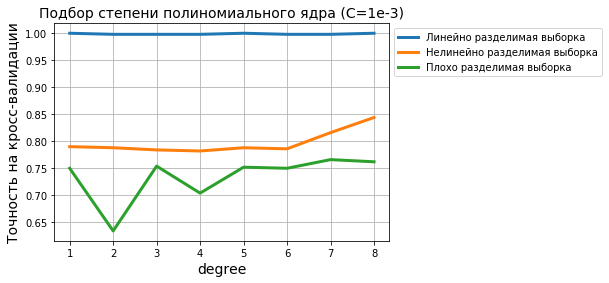

In [553]:
plt.figure()
plt.plot(degrees['degree'], poly_score[0], label='Линейно разделимая выборка', linewidth=3)
plt.plot(degrees['degree'], poly_score[1], label='Нелинейно разделимая выборка', linewidth=3)
plt.plot(degrees['degree'], poly_score[2], label='Плохо разделимая выборка', linewidth=3)
plt.grid()
plt.legend(bbox_to_anchor=(1, 1))
plt.xlabel('degree', fontsize=14)
plt.ylabel('Точность на кросс-валидации', fontsize=14)
plt.title('Подбор степени полиномиального ядра (C=1e-3)', fontsize=14)
plt.savefig('SVM_Report/pict22.pdf', bbox_inches='tight')

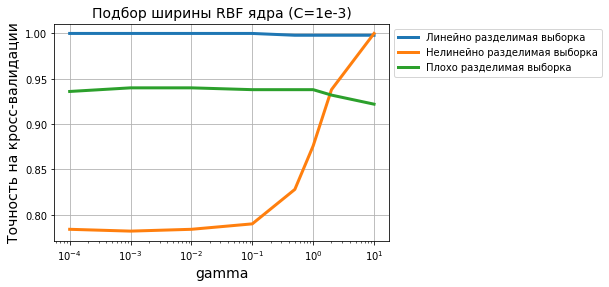

In [552]:
plt.figure()
plt.semilogx(gammas['gamma'], rbf_score[0], label='Линейно разделимая выборка', linewidth=3)
plt.semilogx(gammas['gamma'], rbf_score[1], label='Нелинейно разделимая выборка', linewidth=3)
plt.semilogx(gammas['gamma'], rbf_score[2], label='Плохо разделимая выборка', linewidth=3)
plt.grid()
plt.legend(bbox_to_anchor=(1, 1))
plt.xlabel('gamma', fontsize=14)
plt.ylabel('Точность на кросс-валидации', fontsize=14)
plt.title('Подбор ширины RBF ядра (C=1e-3)', fontsize=14)
plt.savefig('SVM_Report/pict23.pdf', bbox_inches='tight')

## Эксперимент 5

## Эксперимент 6

## Эксперимент 7

## Эксперимент 8

In [374]:
datasets = [create_dataset(complexity='lin_sep', n_features=2, n_samples=200, random_state=42)]

     pcost       dcost       gap    pres   dres
 0: -4.8812e+00 -6.0413e-02  7e+02  3e+01  1e-14
 1: -7.7059e-02 -6.0372e-02  7e+00  3e-01  1e-14
 2: -2.8488e-02 -5.7090e-02  2e-01  6e-03  4e-16
 3: -1.7901e-02 -3.9641e-02  2e-02  5e-18  6e-16
 4: -1.9004e-02 -2.0015e-02  1e-03  1e-18  3e-16
 5: -1.9645e-02 -1.9663e-02  2e-05  3e-18  2e-16
 6: -1.9658e-02 -1.9658e-02  2e-07  7e-18  2e-16
 7: -1.9658e-02 -1.9658e-02  2e-09  8e-18  2e-16
Optimal solution found.


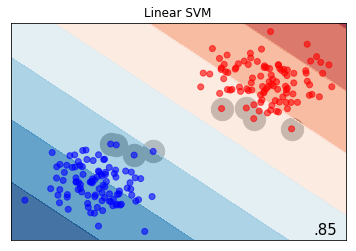

In [379]:
reload(svm)
h = .02  # step size in the mesh

names = ["Linear SVM"]
classifiers = [svm.SVMSolver(method='dual', kernel="linear", C=0.025)]

rng = np.random.RandomState(2)

figure = plt.figure(figsize=(12, 5))
i = 6
# iterate over datasets
for ds in datasets:
    # preprocess dataset, split into training and test part
    X, y = ds

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    #ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    # Plot the training points
    #ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
    # and testing points
    #ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6)
    #ax.set_xlim(xx.min(), xx.max())
    #ax.set_ylim(yy.min(), yy.max())
    #ax.set_xticks(())
    #ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        plt.figure()
        clf.fit(X, y, tolerance=1e-18)
        min_lambda = np.max(clf.lambdas)
        eps = 1 * 1e-12
        plt.scatter(clf.support_vectors[~(clf.lambdas < min_lambda - eps)][:, 0],
                    clf.support_vectors[~(clf.lambdas < min_lambda - eps)][:, 1],
                    s=500, facecolors='black', edgecolors='black')
        # score = clf.score(X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, m_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot also the training points
        plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright,
                   alpha=0.6)

        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())
        plt.xticks(())
        plt.yticks(())
        plt.title(name)
        plt.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
        i += 1
        plt.savefig('SVM_Report/pict' + str(i) + '.pdf')

figure.subplots_adjust(left=.02, right=.98)

In [385]:
datasets = [create_dataset(complexity='lin_sep', n_features=2, n_samples=200, random_state=42),
            create_dataset(complexity='well_sep', n_features=2, n_samples=200, random_state=42)]

     pcost       dcost       gap    pres   dres
 0: -2.9650e+01 -1.2805e+01  7e+02  3e+01  3e-16
 1: -1.2669e+01 -3.7760e+00  5e+01  2e+00  4e-16
 2: -8.0721e-01 -1.9576e+00  1e+00  5e-15  2e-15
 3: -9.2842e-01 -1.0302e+00  1e-01  4e-16  5e-16
 4: -9.9068e-01 -9.9193e-01  1e-03  5e-16  4e-16
 5: -9.9138e-01 -9.9139e-01  1e-05  6e-16  3e-16
 6: -9.9138e-01 -9.9138e-01  1e-07  5e-16  2e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -4.8909e+00 -4.6696e+00  7e+02  3e+01  3e-16
 1: -3.7416e+00 -3.5325e+00  4e+01  1e+00  4e-16
 2: -1.5118e+00 -1.9709e+00  3e+00  1e-01  7e-16
 3: -8.7366e-01 -1.3668e+00  5e-01  3e-16  2e-15
 4: -9.0944e-01 -9.2249e-01  1e-02  9e-17  5e-16
 5: -9.1550e-01 -9.1563e-01  1e-04  2e-16  3e-16
 6: -9.1556e-01 -9.1556e-01  1e-06  1e-16  3e-16
 7: -9.1556e-01 -9.1556e-01  1e-08  3e-16  2e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -4.3125e+00 -3.2211e+00  6e+02  2e+01  7e-16
 1: -2.0704e+00 -2.9171e

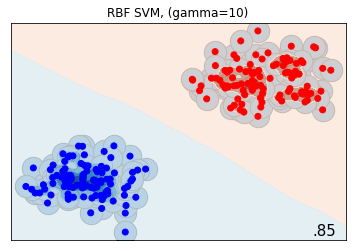

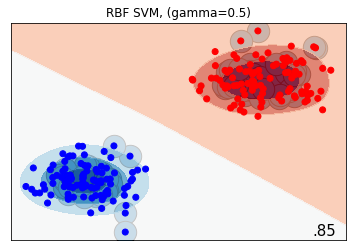

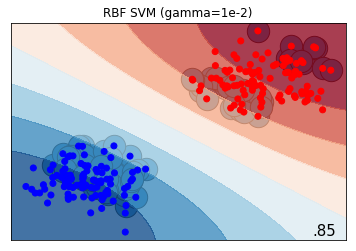

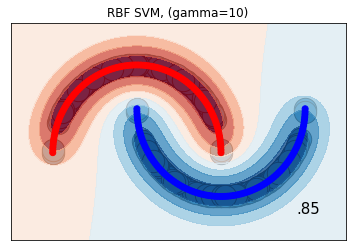

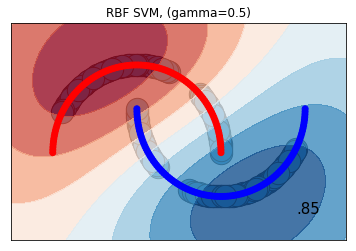

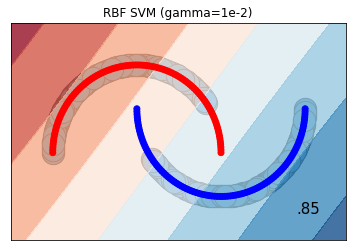

In [401]:
reload(svm)
h = .02  # step size in the mesh

names = ["RBF SVM, (gamma=10)", "RBF SVM, (gamma=0.5)", "RBF SVM (gamma=1e-2)"]
classifiers = [svm.SVMSolver(method='dual', kernel="rbf", C=1, gamma=10),
               svm.SVMSolver(method='dual', kernel="rbf", C=1, gamma=0.5),
               svm.SVMSolver(method='dual', kernel="rbf", C=1, gamma=1e-2)]

rng = np.random.RandomState(2)

i = 10
# iterate over datasets
for ds in datasets:
    # preprocess dataset, split into training and test part
    X, y = ds

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    # Plot the training points
    #plt.figure()
    #plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright)
    # and testing points
    #plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6)
    #plt.xlim(xx.min(), xx.max())
    #plt.ylim(yy.min(), yy.max())
    #plt.xticks(())
    #plt.yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        clf.fit(X, y, tolerance=1e-8)
        # score = clf.score(X_test, y_test)
        plt.figure()
        min_lambda = np.min(clf.lambdas)
        max_lambda = np.max(clf.lambdas)
        plt.scatter(clf.support_vectors[clf.lambdas >= (max_lambda + min_lambda) / 2][:, 0],
                    clf.support_vectors[clf.lambdas >= (max_lambda + min_lambda) / 2][:, 1],
                    s=500, facecolors=None, edgecolors='black')
        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, m_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot also the training points
        plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)

        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())
        plt.xticks(())
        plt.yticks(())
        plt.title(name)
        plt.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
        plt.savefig('SVM_Report/pict' + str(i) + '.pdf')
        i += 1

figure.subplots_adjust(left=.02, right=.98)